# Figures 9 and 10, S. Figure 5 (Molina et al., submitted)

Figure 9. CESM2 composites of the top 25% ACC (using ERA5 as observations) weeks 1-2 mean daily outgoing longwave radiation (OLR; W/m2) and sea surface temperature (SST; °C) anomalies stratified by weeks 3-4 weather regime (WR). Colorbars show CESM2 anomalies for the tropical Pacific (10°S-10°N, 30°E-150°W) OLR (bottom left; a, d, g, j), North Pacific (10°N-48°N, 170°E-110°W) OLR (bottom center; b, e, h, k), and tropical Pacific (10°S-10°N, 120°E-80°W) SSTs (bottom right; c, f, i, l). ERA5 data are shown with black contour lines for comparison to CESM2; the dashed line shows -5 and the solid line shows +5 for ERA5 OLR (left column), the dashed line shows -2.5 and the solid line shows +2.5 for ERA5 OLR (center column), and the dashed line shows -0.5 and the solid line shows +0.5 for ERA5 SSTs (right column). Corresponding ACC for weeks 3-4 weather regimes are shown within each plot, computed using CESM2 and ERA5 500-hPa geopotential height anomalies over North America.

Figure 10. Similar to Fig. 9, but for weeks 3-4 OLR and SSTs, and weeks 5-6 North American weather regimes.

Supplementary Figure 5. CESM2 composites of the top 25% ACC (using ERA5 as observations) weeks 1-2 mean daily outgoing longwave radiation (OLR; W/m2) and sea surface temperature (SST; °C) anomalies stratified by weeks 5-6 weather regime (WR). Colorbars show CESM2 anomalies for the tropical Pacific (10°S-10°N, 30°E-150°W) OLR (bottom left; a, d, g, j), North Pacific (10°N-48°N, 170°E-110°W) OLR (bottom center; b, e, h, k), and tropical Pacific (10°S-10°N, 120°E-80°W) SSTs (bottom right; c, f, i, l). ERA5 data are shown with black contour lines for comparison to CESM2; the dashed line shows -5 and the solid line shows +5 for ERA5 OLR (left column), the dashed line shows -2.5 and the solid line shows +2.5 for ERA5 OLR (center column), and the dashed line shows -0.5 and the solid line shows +0.5 for ERA5 SSTs (right column). Corresponding ACC for weeks 5-6 weather regimes are shown within each plot, computed using CESM2 and ERA5 500-hPa geopotential height anomalies over North America.

## Imports

In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom

from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
import xskillscore as xs

import som_analysis
import cluster_analysis
import narm_analysis

## functions

In [2]:
def get_cold_indx(ds, mo_init=9, mo_end=2):
    """
    Extract indices for cold season.
    Grabbing Sept thru February init, for Oct thru March predictions.
    """
    dt_array = pd.to_datetime(ds['time'])
    return xr.where((dt_array.month >= mo_init) | (dt_array.month <= mo_end),
                    True, False)

## open and preprocess data

In [3]:
# region for clustering
lat0 = 10
lat1 = 70
lon0 = -150
lon1 = -40

# open era5 data and slice
ds_era5 = narm_analysis.era5_z500(lat0=lat0, lat1=lat1, lon0=lon0, lon1=lon1)

# era5 anomalies
ds_era5_anom = narm_analysis.era5_climo_wrs(
    ds_era5, rolling_days=5, variable='clim')

# restructure era5 array for machine learning training (SONDJFM)
ds_era5_anom = ds_era5_anom[get_cold_indx(ds_era5_anom, mo_init=10, mo_end=3),
                            ...]
ds_era5_train = ds_era5_anom.stack(
    flat=('lat', 'lon')).transpose('time', 'flat').values

## pca and kmeans with era5

In [4]:
# create pca object
pca_obj = PCA(12, whiten=True)

# fit pca with era5
pca_obj = pca_obj.fit(ds_era5_train)

# transform era5 data with pca
ds_era5_train = pca_obj.transform(ds_era5_train)

print(f'Variance explained: {pca_obj.explained_variance_ratio_ * 100}')
print(
f'Cumulative sum of variance explained for EOF1 and EOF2: {np.cumsum(pca_obj.explained_variance_ratio_) * 100}'
)

# train kmeans
k_means = KMeans(n_clusters=4,
                 init='k-means++',
                 n_init=10000,
                 max_iter=300,
                 tol=0.0001,
                 verbose=0,
                 random_state=0).fit(ds_era5_train)

print(f'inertia: {k_means.inertia_}')

Variance explained: [25.95315607 17.65410568 11.94871708  9.0784389   7.98100848  6.14181738
  4.32605934  2.61658689  2.22642929  2.17049559  1.49813958  1.22541708]
Cumulative sum of variance explained for EOF1 and EOF2: [25.95315607 43.60726175 55.55597883 64.63441774 72.61542622 78.7572436
 83.08330294 85.69988983 87.92631912 90.09681471 91.59495429 92.82037136]
inertia: 39379.20547871718


## load data with lead time bias corrected anomalies

In [5]:
# era5 data
z500_era5, z500_era5_dt = som_analysis.open_era5_files(
    variable='z500', return_time=True,
    lat0=lat0, lat1=lat1, lon0=lon0, lon1=lon1,
    leadday0=0, leadday1=42, rolldays=5,)

# cesm data
z500_cesm, z500_cesm_dt = som_analysis.open_cesm_files(
    variable='zg_500', return_time=True,
    lat0=lat0, lat1=lat1, lon0=lon0, lon1=lon1,
    leadday0=0, leadday1=42, rolldays=5,)

# restructure arrays
z500_standard_era5 = z500_era5.stack(
    new=('time', 'lead'), flat=('lat', 'lon')).transpose('new', 'flat')
z500_standard_cesm = z500_cesm.stack(
    new=('time', 'lead'), flat=('lat', 'lon')).transpose('new', 'flat')

## outgoing longwave radiation (tropical Pac)

In [6]:
# era5 data
rlut_era5, _ = som_analysis.open_era5_files(
    variable='ttr', return_time=True,
    lat0=-10, lat1=10, lon0=30-360, lon1=-150,
    leadday0=0, leadday1=42, rolldays=5)

# cesm data
rlut_cesm, _ = som_analysis.open_cesm_files(
    variable='rlut', return_time=True,
    lat0=-10, lat1=10, lon0=30-360, lon1=-150,
    leadday0=0, leadday1=42, rolldays=5)

# restructure data array
rlut_era5_tmp = rlut_era5.stack(
    new=('time', 'lead'), flat=('lat', 'lon')).transpose('new', 'flat')
rlut_cesm_tmp = rlut_cesm.stack(
    new=('time', 'lead'), flat=('lat', 'lon')).transpose('new', 'flat')

In [7]:
lons_tpac, lats_tpac = np.meshgrid(
    rlut_era5_tmp.unstack('flat').lon.values,
    rlut_era5_tmp.unstack('flat').lat.values)

## weeks 1-2 and weeks 3-4

In [8]:
firstday = 1
seconday = 14

rlut_era5_tmp1 = rlut_era5_tmp.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True).values

rlut_cesm_tmp1 = rlut_cesm_tmp.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True).values

In [9]:
firstday = 15
seconday = 28

z500_era5_tmp1 = z500_standard_era5.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True)

z500_cesm_tmp1 = z500_standard_cesm.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True)

z500_era5_tmp1__ = z500_era5_tmp1.stack(
    flat=('lat', 'lon')).transpose('time', 'flat').values
z500_cesm_tmp1__ = z500_cesm_tmp1.stack(
    flat=('lat', 'lon')).transpose('time', 'flat').values

z500_era5_tmp1 = z500_era5_tmp1.values
z500_cesm_tmp1 = z500_cesm_tmp1.values

In [10]:
rlut_acc_ = []
rlut_mse_ = []
wr_acc_ = []
wr_mse_ = []
cluster_ = []
leadtime_ = []
indices_ = []

for i in range(rlut_era5_tmp1.shape[0]):

    nan_indx = np.argwhere(np.isnan(rlut_cesm_tmp1[i, :, :].flatten()))

    try:

        rlut_acc_.append(stats.pearsonr(
            np.delete(rlut_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(-rlut_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        )[0])

        rlut_mse_.append(metrics.mean_squared_error(
            np.delete(rlut_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(-rlut_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        ))

        wr_acc_.append(stats.pearsonr(
            np.delete(z500_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(z500_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        )[0])

        wr_mse_.append(metrics.mean_squared_error(
            np.delete(z500_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(z500_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        ))

        cluster_.append(cluster_analysis.grab_cluster(
            z500_cesm_tmp1__[i].reshape(1, -1),
            k_means, pca_obj, use_pca=True)[0])

        indices_.append(i)

    except ValueError:

        continue

rlut_acc_ = np.array(rlut_acc_)
rlut_mse_ = np.array(rlut_mse_)
wr_acc_ = np.array(wr_acc_)
wr_mse_ = np.array(wr_mse_)
cluster_ = np.array(cluster_)
indices_ = np.array(indices_)

In [11]:
percent_threshold = 75

In [12]:
all0_tpac_1234 = np.nanmean(wr_acc_[(cluster_ == 0)])
all1_tpac_1234 = np.nanmean(wr_acc_[(cluster_ == 1)])
all2_tpac_1234 = np.nanmean(wr_acc_[(cluster_ == 2)])
all3_tpac_1234 = np.nanmean(wr_acc_[(cluster_ == 3)])

top0_tpac_1234 = np.nanmean(
    wr_acc_[(cluster_ == 0)][rlut_acc_[(cluster_ == 0)] >= np.nanpercentile(
        rlut_acc_[(cluster_ == 0)], percent_threshold)])
top1_tpac_1234 = np.nanmean(
    wr_acc_[(cluster_ == 1)][rlut_acc_[(cluster_ == 1)] >= np.nanpercentile(
        rlut_acc_[(cluster_ == 1)], percent_threshold)])
top2_tpac_1234 = np.nanmean(
    wr_acc_[(cluster_ == 2)][rlut_acc_[(cluster_ == 2)] >= np.nanpercentile(
        rlut_acc_[(cluster_ == 2)], percent_threshold)])
top3_tpac_1234 = np.nanmean(
    wr_acc_[(cluster_ == 3)][rlut_acc_[(cluster_ == 3)] >= np.nanpercentile(
        rlut_acc_[(cluster_ == 3)], percent_threshold)])

topindx0_tpac_1234 = np.where(rlut_acc_[(cluster_ == 0)] >= np.nanpercentile(
    rlut_acc_[(cluster_ == 0)], percent_threshold), indices_[(cluster_ == 0)], np.nan)
topindx1_tpac_1234 = np.where(rlut_acc_[(cluster_ == 1)] >= np.nanpercentile(
    rlut_acc_[(cluster_ == 1)], percent_threshold), indices_[(cluster_ == 1)], np.nan)
topindx2_tpac_1234 = np.where(rlut_acc_[(cluster_ == 2)] >= np.nanpercentile(
    rlut_acc_[(cluster_ == 2)], percent_threshold), indices_[(cluster_ == 2)], np.nan)
topindx3_tpac_1234 = np.where(rlut_acc_[(cluster_ == 3)] >= np.nanpercentile(
    rlut_acc_[(cluster_ == 3)], percent_threshold), indices_[(cluster_ == 3)], np.nan)

In [13]:
era5_c0_tpac_1234 = np.nanmean(
    -rlut_era5_tmp1[topindx0_tpac_1234[~np.isnan(
        topindx0_tpac_1234)].astype(int), :, :], axis=0)

era5_c1_tpac_1234 = np.nanmean(
    -rlut_era5_tmp1[topindx1_tpac_1234[~np.isnan(
        topindx1_tpac_1234)].astype(int), :, :], axis=0)

era5_c2_tpac_1234 = np.nanmean(
    -rlut_era5_tmp1[topindx2_tpac_1234[~np.isnan(
        topindx2_tpac_1234)].astype(int), :, :], axis=0)

era5_c3_tpac_1234 = np.nanmean(
    -rlut_era5_tmp1[topindx3_tpac_1234[~np.isnan(
        topindx3_tpac_1234)].astype(int), :, :], axis=0)

cesm_c0_tpac_1234 = np.nanmean(
    rlut_cesm_tmp1[topindx0_tpac_1234[~np.isnan(
        topindx0_tpac_1234)].astype(int), :, :], axis=0)

cesm_c1_tpac_1234 = np.nanmean(
    rlut_cesm_tmp1[topindx1_tpac_1234[~np.isnan(
        topindx1_tpac_1234)].astype(int), :, :], axis=0)

cesm_c2_tpac_1234 = np.nanmean(
    rlut_cesm_tmp1[topindx2_tpac_1234[~np.isnan(
        topindx2_tpac_1234)].astype(int), :, :], axis=0)

cesm_c3_tpac_1234 = np.nanmean(
    rlut_cesm_tmp1[topindx3_tpac_1234[~np.isnan(
        topindx3_tpac_1234)].astype(int), :, :], axis=0)

## weeks 3-4 and weeks 5-6

In [14]:
firstday = 15
seconday = 28

rlut_era5_tmp1 = rlut_era5_tmp.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True).values

rlut_cesm_tmp1 = rlut_cesm_tmp.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True).values

In [15]:
firstday = 29
seconday = 42

z500_era5_tmp1 = z500_standard_era5.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True)

z500_cesm_tmp1 = z500_standard_cesm.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True)

z500_era5_tmp1__ = z500_era5_tmp1.stack(
    flat=('lat', 'lon')).transpose('time', 'flat').values
z500_cesm_tmp1__ = z500_cesm_tmp1.stack(
    flat=('lat', 'lon')).transpose('time', 'flat').values

z500_era5_tmp1 = z500_era5_tmp1.values
z500_cesm_tmp1 = z500_cesm_tmp1.values

In [16]:
rlut_acc_ = []
rlut_mse_ = []
wr_acc_ = []
wr_mse_ = []
cluster_ = []
leadtime_ = []
indices_ = []

for i in range(rlut_era5_tmp1.shape[0]):

    nan_indx = np.argwhere(np.isnan(rlut_cesm_tmp1[i, :, :].flatten()))

    try:

        rlut_acc_.append(stats.pearsonr(
            np.delete(rlut_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(-rlut_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        )[0])

        rlut_mse_.append(metrics.mean_squared_error(
            np.delete(rlut_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(-rlut_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        ))

        wr_acc_.append(stats.pearsonr(
            np.delete(z500_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(z500_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        )[0])

        wr_mse_.append(metrics.mean_squared_error(
            np.delete(z500_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(z500_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        ))

        cluster_.append(cluster_analysis.grab_cluster(
            z500_cesm_tmp1__[i].reshape(1, -1),
            k_means, pca_obj, use_pca=True)[0])

        indices_.append(i)

    except ValueError:

        continue

rlut_acc_ = np.array(rlut_acc_)
rlut_mse_ = np.array(rlut_mse_)
wr_acc_ = np.array(wr_acc_)
wr_mse_ = np.array(wr_mse_)
cluster_ = np.array(cluster_)
indices_ = np.array(indices_)

In [17]:
all0_tpac_3456 = np.nanmean(wr_acc_[(cluster_ == 0)])
all1_tpac_3456 = np.nanmean(wr_acc_[(cluster_ == 1)])
all2_tpac_3456 = np.nanmean(wr_acc_[(cluster_ == 2)])
all3_tpac_3456 = np.nanmean(wr_acc_[(cluster_ == 3)])

top0_tpac_3456 = np.nanmean(
    wr_acc_[(cluster_ == 0)][rlut_acc_[(cluster_ == 0)] >= np.nanpercentile(
        rlut_acc_[(cluster_ == 0)], percent_threshold)])
top1_tpac_3456 = np.nanmean(
    wr_acc_[(cluster_ == 1)][rlut_acc_[(cluster_ == 1)] >= np.nanpercentile(
        rlut_acc_[(cluster_ == 1)], percent_threshold)])
top2_tpac_3456 = np.nanmean(
    wr_acc_[(cluster_ == 2)][rlut_acc_[(cluster_ == 2)] >= np.nanpercentile(
        rlut_acc_[(cluster_ == 2)], percent_threshold)])
top3_tpac_3456 = np.nanmean(
    wr_acc_[(cluster_ == 3)][rlut_acc_[(cluster_ == 3)] >= np.nanpercentile(
        rlut_acc_[(cluster_ == 3)], percent_threshold)])

topindx0_tpac_3456 = np.where(rlut_acc_[(cluster_ == 0)] >= np.nanpercentile(
    rlut_acc_[(cluster_ == 0)], percent_threshold), indices_[(cluster_ == 0)], np.nan)
topindx1_tpac_3456 = np.where(rlut_acc_[(cluster_ == 1)] >= np.nanpercentile(
    rlut_acc_[(cluster_ == 1)], percent_threshold), indices_[(cluster_ == 1)], np.nan)
topindx2_tpac_3456 = np.where(rlut_acc_[(cluster_ == 2)] >= np.nanpercentile(
    rlut_acc_[(cluster_ == 2)], percent_threshold), indices_[(cluster_ == 2)], np.nan)
topindx3_tpac_3456 = np.where(rlut_acc_[(cluster_ == 3)] >= np.nanpercentile(
    rlut_acc_[(cluster_ == 3)], percent_threshold), indices_[(cluster_ == 3)], np.nan)

In [18]:
era5_c0_tpac_3456 = np.nanmean(
    -rlut_era5_tmp1[topindx0_tpac_3456[~np.isnan(
        topindx0_tpac_3456)].astype(int), :, :], axis=0)

era5_c1_tpac_3456 = np.nanmean(
    -rlut_era5_tmp1[topindx1_tpac_3456[~np.isnan(
        topindx1_tpac_3456)].astype(int), :, :], axis=0)

era5_c2_tpac_3456 = np.nanmean(
    -rlut_era5_tmp1[topindx2_tpac_3456[~np.isnan(
        topindx2_tpac_3456)].astype(int), :, :], axis=0)

era5_c3_tpac_3456 = np.nanmean(
    -rlut_era5_tmp1[topindx3_tpac_3456[~np.isnan(
        topindx3_tpac_3456)].astype(int), :, :], axis=0)

cesm_c0_tpac_3456 = np.nanmean(
    rlut_cesm_tmp1[topindx0_tpac_3456[~np.isnan(
        topindx0_tpac_3456)].astype(int), :, :], axis=0)

cesm_c1_tpac_3456 = np.nanmean(
    rlut_cesm_tmp1[topindx1_tpac_3456[~np.isnan(
        topindx1_tpac_3456)].astype(int), :, :], axis=0)

cesm_c2_tpac_3456 = np.nanmean(
    rlut_cesm_tmp1[topindx2_tpac_3456[~np.isnan(
        topindx2_tpac_3456)].astype(int), :, :], axis=0)

cesm_c3_tpac_3456 = np.nanmean(
    rlut_cesm_tmp1[topindx3_tpac_3456[~np.isnan(
        topindx3_tpac_3456)].astype(int), :, :], axis=0)

## weeks 1-2 and weeks 5-6

In [19]:
firstday = 1
seconday = 14

rlut_era5_tmp1 = rlut_era5_tmp.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True).values

rlut_cesm_tmp1 = rlut_cesm_tmp.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True).values

In [20]:
firstday = 29
seconday = 42

z500_era5_tmp1 = z500_standard_era5.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True)

z500_cesm_tmp1 = z500_standard_cesm.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True)

z500_era5_tmp1__ = z500_era5_tmp1.stack(
    flat=('lat', 'lon')).transpose('time', 'flat').values
z500_cesm_tmp1__ = z500_cesm_tmp1.stack(
    flat=('lat', 'lon')).transpose('time', 'flat').values

z500_era5_tmp1 = z500_era5_tmp1.values
z500_cesm_tmp1 = z500_cesm_tmp1.values

In [21]:
rlut_acc_ = []
rlut_mse_ = []

wr_acc_ = []
wr_mse_ = []

cluster_ = []
leadtime_ = []
indices_ = []

for i in range(rlut_era5_tmp1.shape[0]):

    nan_indx = np.argwhere(np.isnan(rlut_cesm_tmp1[i, :, :].flatten()))

    try:

        rlut_acc_.append(stats.pearsonr(
            np.delete(rlut_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(-rlut_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        )[0])

        rlut_mse_.append(metrics.mean_squared_error(
            np.delete(rlut_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(-rlut_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        ))

        wr_acc_.append(stats.pearsonr(
            np.delete(z500_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(z500_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        )[0])

        wr_mse_.append(metrics.mean_squared_error(
            np.delete(z500_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(z500_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        ))

        cluster_.append(cluster_analysis.grab_cluster(
            z500_cesm_tmp1__[i].reshape(1, -1),
            k_means, pca_obj, use_pca=True)[0])

        indices_.append(i)

    except ValueError:

        continue

rlut_acc_ = np.array(rlut_acc_)
rlut_mse_ = np.array(rlut_mse_)
wr_acc_ = np.array(wr_acc_)
wr_mse_ = np.array(wr_mse_)
cluster_ = np.array(cluster_)
indices_ = np.array(indices_)

In [22]:
all0_tpac_1256 = np.nanmean(wr_acc_[(cluster_ == 0)])
all1_tpac_1256 = np.nanmean(wr_acc_[(cluster_ == 1)])
all2_tpac_1256 = np.nanmean(wr_acc_[(cluster_ == 2)])
all3_tpac_1256 = np.nanmean(wr_acc_[(cluster_ == 3)])

top0_tpac_1256 = np.nanmean(
    wr_acc_[(cluster_ == 0)][rlut_acc_[(cluster_ == 0)] >= np.nanpercentile(
        rlut_acc_[(cluster_ == 0)], percent_threshold)])
top1_tpac_1256 = np.nanmean(
    wr_acc_[(cluster_ == 1)][rlut_acc_[(cluster_ == 1)] >= np.nanpercentile(
        rlut_acc_[(cluster_ == 1)], percent_threshold)])
top2_tpac_1256 = np.nanmean(
    wr_acc_[(cluster_ == 2)][rlut_acc_[(cluster_ == 2)] >= np.nanpercentile(
        rlut_acc_[(cluster_ == 2)], percent_threshold)])
top3_tpac_1256 = np.nanmean(
    wr_acc_[(cluster_ == 3)][rlut_acc_[(cluster_ == 3)] >= np.nanpercentile(
        rlut_acc_[(cluster_ == 3)], percent_threshold)])

topindx0_tpac_1256 = np.where(rlut_acc_[(cluster_ == 0)] >= np.nanpercentile(
    rlut_acc_[(cluster_ == 0)], percent_threshold), indices_[(cluster_ == 0)], np.nan)
topindx1_tpac_1256 = np.where(rlut_acc_[(cluster_ == 1)] >= np.nanpercentile(
    rlut_acc_[(cluster_ == 1)], percent_threshold), indices_[(cluster_ == 1)], np.nan)
topindx2_tpac_1256 = np.where(rlut_acc_[(cluster_ == 2)] >= np.nanpercentile(
    rlut_acc_[(cluster_ == 2)], percent_threshold), indices_[(cluster_ == 2)], np.nan)
topindx3_tpac_1256 = np.where(rlut_acc_[(cluster_ == 3)] >= np.nanpercentile(
    rlut_acc_[(cluster_ == 3)], percent_threshold), indices_[(cluster_ == 3)], np.nan)

In [23]:
era5_c0_tpac_1256 = np.nanmean(
    -rlut_era5_tmp1[topindx0_tpac_1256[~np.isnan(
        topindx0_tpac_1256)].astype(int), :, :], axis=0)

era5_c1_tpac_1256 = np.nanmean(
    -rlut_era5_tmp1[topindx1_tpac_1256[~np.isnan(
        topindx1_tpac_1256)].astype(int), :, :], axis=0)

era5_c2_tpac_1256 = np.nanmean(
    -rlut_era5_tmp1[topindx2_tpac_1256[~np.isnan(
        topindx2_tpac_1256)].astype(int), :, :], axis=0)

era5_c3_tpac_1256 = np.nanmean(
    -rlut_era5_tmp1[topindx3_tpac_1256[~np.isnan(
        topindx3_tpac_1256)].astype(int), :, :], axis=0)

cesm_c0_tpac_1256 = np.nanmean(
    rlut_cesm_tmp1[topindx0_tpac_1256[~np.isnan(
        topindx0_tpac_1256)].astype(int), :, :], axis=0)

cesm_c1_tpac_1256 = np.nanmean(
    rlut_cesm_tmp1[topindx1_tpac_1256[~np.isnan(
        topindx1_tpac_1256)].astype(int), :, :], axis=0)

cesm_c2_tpac_1256 = np.nanmean(
    rlut_cesm_tmp1[topindx2_tpac_1256[~np.isnan(
        topindx2_tpac_1256)].astype(int), :, :], axis=0)

cesm_c3_tpac_1256 = np.nanmean(
    rlut_cesm_tmp1[topindx3_tpac_1256[~np.isnan(
        topindx3_tpac_1256)].astype(int), :, :], axis=0)

## outgoing longwave radiation (north pac)

In [24]:
# era5 data
rlut_era5, _ = som_analysis.open_era5_files(
    variable='ttr', return_time=True,
    lat0=10, lat1=48, lon0=170-360, lon1=250-360,
    leadday0=0, leadday1=42, rolldays=5,)

# cesm data
rlut_cesm, _ = som_analysis.open_cesm_files(
    variable='rlut', return_time=True,
    lat0=10, lat1=48, lon0=170-360, lon1=250-360,
    leadday0=0, leadday1=42, rolldays=5,)

# restructure data array
rlut_era5_tmp = rlut_era5.stack(
    new=('time', 'lead'), flat=('lat', 'lon')).transpose('new', 'flat')
rlut_cesm_tmp = rlut_cesm.stack(
    new=('time', 'lead'), flat=('lat', 'lon')).transpose('new', 'flat')

In [25]:
lons_npac, lats_npac = np.meshgrid(
    rlut_era5_tmp.unstack('flat').lon.values,
    rlut_era5_tmp.unstack('flat').lat.values)

## weeks 1-2 and weeks 3-4

In [26]:
firstday = 1
seconday = 14

rlut_era5_tmp1 = rlut_era5_tmp.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True).values

rlut_cesm_tmp1 = rlut_cesm_tmp.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True).values

In [27]:
firstday = 15
seconday = 28

z500_era5_tmp1 = z500_standard_era5.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True)

z500_cesm_tmp1 = z500_standard_cesm.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True)

z500_era5_tmp1__ = z500_era5_tmp1.stack(
    flat=('lat', 'lon')).transpose('time', 'flat').values
z500_cesm_tmp1__ = z500_cesm_tmp1.stack(
    flat=('lat', 'lon')).transpose('time', 'flat').values

z500_era5_tmp1 = z500_era5_tmp1.values
z500_cesm_tmp1 = z500_cesm_tmp1.values

In [28]:
rlut_acc_ = []
rlut_mse_ = []

wr_acc_ = []
wr_mse_ = []

cluster_ = []
leadtime_ = []
indices_ = []

for i in range(rlut_era5_tmp1.shape[0]):

    nan_indx = np.argwhere(np.isnan(rlut_cesm_tmp1[i, :, :].flatten()))

    try:

        rlut_acc_.append(stats.pearsonr(
            np.delete(rlut_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(-rlut_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        )[0])

        rlut_mse_.append(metrics.mean_squared_error(
            np.delete(rlut_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(-rlut_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        ))

        wr_acc_.append(stats.pearsonr(
            np.delete(z500_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(z500_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        )[0])

        wr_mse_.append(metrics.mean_squared_error(
            np.delete(z500_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(z500_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        ))

        cluster_.append(cluster_analysis.grab_cluster(
            z500_cesm_tmp1__[i].reshape(1, -1),
            k_means, pca_obj, use_pca=True)[0])

        indices_.append(i)

    except ValueError:

        continue

rlut_acc_ = np.array(rlut_acc_)
rlut_mse_ = np.array(rlut_mse_)
wr_acc_ = np.array(wr_acc_)
wr_mse_ = np.array(wr_mse_)
cluster_ = np.array(cluster_)
indices_ = np.array(indices_)

In [29]:
all0_npac_1234 = np.nanmean(wr_acc_[(cluster_ == 0)])
all1_npac_1234 = np.nanmean(wr_acc_[(cluster_ == 1)])
all2_npac_1234 = np.nanmean(wr_acc_[(cluster_ == 2)])
all3_npac_1234 = np.nanmean(wr_acc_[(cluster_ == 3)])

top0_npac_1234 = np.nanmean(
    wr_acc_[(cluster_ == 0)][rlut_acc_[(cluster_ == 0)] >= np.nanpercentile(
        rlut_acc_[(cluster_ == 0)], percent_threshold)])
top1_npac_1234 = np.nanmean(
    wr_acc_[(cluster_ == 1)][rlut_acc_[(cluster_ == 1)] >= np.nanpercentile(
        rlut_acc_[(cluster_ == 1)], percent_threshold)])
top2_npac_1234 = np.nanmean(
    wr_acc_[(cluster_ == 2)][rlut_acc_[(cluster_ == 2)] >= np.nanpercentile(
        rlut_acc_[(cluster_ == 2)], percent_threshold)])
top3_npac_1234 = np.nanmean(
    wr_acc_[(cluster_ == 3)][rlut_acc_[(cluster_ == 3)] >= np.nanpercentile(
        rlut_acc_[(cluster_ == 3)], percent_threshold)])

topindx0_npac_1234 = np.where(rlut_acc_[(cluster_ == 0)] >= np.nanpercentile(
    rlut_acc_[(cluster_ == 0)], percent_threshold), indices_[(cluster_ == 0)], np.nan)
topindx1_npac_1234 = np.where(rlut_acc_[(cluster_ == 1)] >= np.nanpercentile(
    rlut_acc_[(cluster_ == 1)], percent_threshold), indices_[(cluster_ == 1)], np.nan)
topindx2_npac_1234 = np.where(rlut_acc_[(cluster_ == 2)] >= np.nanpercentile(
    rlut_acc_[(cluster_ == 2)], percent_threshold), indices_[(cluster_ == 2)], np.nan)
topindx3_npac_1234 = np.where(rlut_acc_[(cluster_ == 3)] >= np.nanpercentile(
    rlut_acc_[(cluster_ == 3)], percent_threshold), indices_[(cluster_ == 3)], np.nan)

In [30]:
era5_c0_npac_1234 = np.nanmean(
    -rlut_era5_tmp1[topindx0_npac_1234[~np.isnan(
        topindx0_npac_1234)].astype(int), :, :], axis=0)

era5_c1_npac_1234 = np.nanmean(
    -rlut_era5_tmp1[topindx1_npac_1234[~np.isnan(
        topindx1_npac_1234)].astype(int), :, :], axis=0)

era5_c2_npac_1234 = np.nanmean(
    -rlut_era5_tmp1[topindx2_npac_1234[~np.isnan(
        topindx2_npac_1234)].astype(int), :, :], axis=0)

era5_c3_npac_1234 = np.nanmean(
    -rlut_era5_tmp1[topindx3_npac_1234[~np.isnan(
        topindx3_npac_1234)].astype(int), :, :], axis=0)

cesm_c0_npac_1234 = np.nanmean(
    rlut_cesm_tmp1[topindx0_npac_1234[~np.isnan(
        topindx0_npac_1234)].astype(int), :, :], axis=0)

cesm_c1_npac_1234 = np.nanmean(
    rlut_cesm_tmp1[topindx1_npac_1234[~np.isnan(
        topindx1_npac_1234)].astype(int), :, :], axis=0)

cesm_c2_npac_1234 = np.nanmean(
    rlut_cesm_tmp1[topindx2_npac_1234[~np.isnan(
        topindx2_npac_1234)].astype(int), :, :], axis=0)

cesm_c3_npac_1234 = np.nanmean(
    rlut_cesm_tmp1[topindx3_npac_1234[~np.isnan(
        topindx3_npac_1234)].astype(int), :, :], axis=0)

## weeks 3-4 and weeks 5-6

In [31]:
firstday = 15
seconday = 28

rlut_era5_tmp1 = rlut_era5_tmp.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True).values

rlut_cesm_tmp1 = rlut_cesm_tmp.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True).values

In [32]:
firstday = 29
seconday = 42

z500_era5_tmp1 = z500_standard_era5.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True)

z500_cesm_tmp1 = z500_standard_cesm.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True)

z500_era5_tmp1__ = z500_era5_tmp1.stack(
    flat=('lat', 'lon')).transpose('time', 'flat').values
z500_cesm_tmp1__ = z500_cesm_tmp1.stack(
    flat=('lat', 'lon')).transpose('time', 'flat').values

z500_era5_tmp1 = z500_era5_tmp1.values
z500_cesm_tmp1 = z500_cesm_tmp1.values

In [33]:
rlut_acc_ = []
rlut_mse_ = []

wr_acc_ = []
wr_mse_ = []

cluster_ = []
leadtime_ = []
indices_ = []

for i in range(rlut_era5_tmp1.shape[0]):

    nan_indx = np.argwhere(np.isnan(rlut_cesm_tmp1[i, :, :].flatten()))

    try:

        rlut_acc_.append(stats.pearsonr(
            np.delete(rlut_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(-rlut_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        )[0])

        rlut_mse_.append(metrics.mean_squared_error(
            np.delete(rlut_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(-rlut_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        ))

        wr_acc_.append(stats.pearsonr(
            np.delete(z500_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(z500_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        )[0])

        wr_mse_.append(metrics.mean_squared_error(
            np.delete(z500_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(z500_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        ))

        cluster_.append(cluster_analysis.grab_cluster(
            z500_cesm_tmp1__[i].reshape(1, -1),
            k_means, pca_obj, use_pca=True)[0])

        indices_.append(i)

    except ValueError:

        continue

rlut_acc_ = np.array(rlut_acc_)
rlut_mse_ = np.array(rlut_mse_)
wr_acc_ = np.array(wr_acc_)
wr_mse_ = np.array(wr_mse_)
cluster_ = np.array(cluster_)
indices_ = np.array(indices_)

In [34]:
all0_npac_3456 = np.nanmean(wr_acc_[(cluster_ == 0)])
all1_npac_3456 = np.nanmean(wr_acc_[(cluster_ == 1)])
all2_npac_3456 = np.nanmean(wr_acc_[(cluster_ == 2)])
all3_npac_3456 = np.nanmean(wr_acc_[(cluster_ == 3)])

top0_npac_3456 = np.nanmean(
    wr_acc_[(cluster_ == 0)][rlut_acc_[(cluster_ == 0)] >= np.nanpercentile(
        rlut_acc_[(cluster_ == 0)], percent_threshold)])
top1_npac_3456 = np.nanmean(
    wr_acc_[(cluster_ == 1)][rlut_acc_[(cluster_ == 1)] >= np.nanpercentile(
        rlut_acc_[(cluster_ == 1)], percent_threshold)])
top2_npac_3456 = np.nanmean(
    wr_acc_[(cluster_ == 2)][rlut_acc_[(cluster_ == 2)] >= np.nanpercentile(
        rlut_acc_[(cluster_ == 2)], percent_threshold)])
top3_npac_3456 = np.nanmean(
    wr_acc_[(cluster_ == 3)][rlut_acc_[(cluster_ == 3)] >= np.nanpercentile(
        rlut_acc_[(cluster_ == 3)], percent_threshold)])

topindx0_npac_3456 = np.where(rlut_acc_[(cluster_ == 0)] >= np.nanpercentile(
    rlut_acc_[(cluster_ == 0)], percent_threshold), indices_[(cluster_ == 0)], np.nan)
topindx1_npac_3456 = np.where(rlut_acc_[(cluster_ == 1)] >= np.nanpercentile(
    rlut_acc_[(cluster_ == 1)], percent_threshold), indices_[(cluster_ == 1)], np.nan)
topindx2_npac_3456 = np.where(rlut_acc_[(cluster_ == 2)] >= np.nanpercentile(
    rlut_acc_[(cluster_ == 2)], percent_threshold), indices_[(cluster_ == 2)], np.nan)
topindx3_npac_3456 = np.where(rlut_acc_[(cluster_ == 3)] >= np.nanpercentile(
    rlut_acc_[(cluster_ == 3)], percent_threshold), indices_[(cluster_ == 3)], np.nan)

In [35]:
era5_c0_npac_3456 = np.nanmean(
    -rlut_era5_tmp1[topindx0_npac_3456[~np.isnan(
        topindx0_npac_3456)].astype(int), :, :], axis=0)

era5_c1_npac_3456 = np.nanmean(
    -rlut_era5_tmp1[topindx1_npac_3456[~np.isnan(
        topindx1_npac_3456)].astype(int), :, :], axis=0)

era5_c2_npac_3456 = np.nanmean(
    -rlut_era5_tmp1[topindx2_npac_3456[~np.isnan(
        topindx2_npac_3456)].astype(int), :, :], axis=0)

era5_c3_npac_3456 = np.nanmean(
    -rlut_era5_tmp1[topindx3_npac_3456[~np.isnan(
        topindx3_npac_3456)].astype(int), :, :], axis=0)

cesm_c0_npac_3456 = np.nanmean(
    rlut_cesm_tmp1[topindx0_npac_3456[~np.isnan(
        topindx0_npac_3456)].astype(int), :, :], axis=0)

cesm_c1_npac_3456 = np.nanmean(
    rlut_cesm_tmp1[topindx1_npac_3456[~np.isnan(
        topindx1_npac_3456)].astype(int), :, :], axis=0)

cesm_c2_npac_3456 = np.nanmean(
    rlut_cesm_tmp1[topindx2_npac_3456[~np.isnan(
        topindx2_npac_3456)].astype(int), :, :], axis=0)

cesm_c3_npac_3456 = np.nanmean(
    rlut_cesm_tmp1[topindx3_npac_3456[~np.isnan(
        topindx3_npac_3456)].astype(int), :, :], axis=0)

## weeks 1-2 and weeks 5-6

In [36]:
firstday = 1
seconday = 14

rlut_era5_tmp1 = rlut_era5_tmp.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True).values

rlut_cesm_tmp1 = rlut_cesm_tmp.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True).values

In [37]:
firstday = 29
seconday = 42

z500_era5_tmp1 = z500_standard_era5.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True)

z500_cesm_tmp1 = z500_standard_cesm.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True)

z500_era5_tmp1__ = z500_era5_tmp1.stack(
    flat=('lat', 'lon')).transpose('time', 'flat').values
z500_cesm_tmp1__ = z500_cesm_tmp1.stack(
    flat=('lat', 'lon')).transpose('time', 'flat').values

z500_era5_tmp1 = z500_era5_tmp1.values
z500_cesm_tmp1 = z500_cesm_tmp1.values

In [38]:
rlut_acc_ = []
rlut_mse_ = []

wr_acc_ = []
wr_mse_ = []

cluster_ = []
leadtime_ = []
indices_ = []

for i in range(rlut_era5_tmp1.shape[0]):

    nan_indx = np.argwhere(np.isnan(rlut_cesm_tmp1[i, :, :].flatten()))

    try:

        rlut_acc_.append(stats.pearsonr(
            np.delete(rlut_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(-rlut_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        )[0])

        rlut_mse_.append(metrics.mean_squared_error(
            np.delete(rlut_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(-rlut_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        ))

        wr_acc_.append(stats.pearsonr(
            np.delete(z500_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(z500_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        )[0])

        wr_mse_.append(metrics.mean_squared_error(
            np.delete(z500_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(z500_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        ))

        cluster_.append(cluster_analysis.grab_cluster(
            z500_cesm_tmp1__[i].reshape(1, -1),
            k_means, pca_obj, use_pca=True)[0])

        indices_.append(i)

    except ValueError:

        continue

rlut_acc_ = np.array(rlut_acc_)
rlut_mse_ = np.array(rlut_mse_)
wr_acc_ = np.array(wr_acc_)
wr_mse_ = np.array(wr_mse_)
cluster_ = np.array(cluster_)
indices_ = np.array(indices_)

In [39]:
all0_npac_1256 = np.nanmean(wr_acc_[(cluster_ == 0)])
all1_npac_1256 = np.nanmean(wr_acc_[(cluster_ == 1)])
all2_npac_1256 = np.nanmean(wr_acc_[(cluster_ == 2)])
all3_npac_1256 = np.nanmean(wr_acc_[(cluster_ == 3)])

top0_npac_1256 = np.nanmean(
    wr_acc_[(cluster_ == 0)][rlut_acc_[(cluster_ == 0)] >= np.nanpercentile(
        rlut_acc_[(cluster_ == 0)], percent_threshold)])
top1_npac_1256 = np.nanmean(
    wr_acc_[(cluster_ == 1)][rlut_acc_[(cluster_ == 1)] >= np.nanpercentile(
        rlut_acc_[(cluster_ == 1)], percent_threshold)])
top2_npac_1256 = np.nanmean(
    wr_acc_[(cluster_ == 2)][rlut_acc_[(cluster_ == 2)] >= np.nanpercentile(
        rlut_acc_[(cluster_ == 2)], percent_threshold)])
top3_npac_1256 = np.nanmean(
    wr_acc_[(cluster_ == 3)][rlut_acc_[(cluster_ == 3)] >= np.nanpercentile(
        rlut_acc_[(cluster_ == 3)], percent_threshold)])

topindx0_npac_1256 = np.where(rlut_acc_[(cluster_ == 0)] >= np.nanpercentile(
    rlut_acc_[(cluster_ == 0)], percent_threshold), indices_[(cluster_ == 0)], np.nan)
topindx1_npac_1256 = np.where(rlut_acc_[(cluster_ == 1)] >= np.nanpercentile(
    rlut_acc_[(cluster_ == 1)], percent_threshold), indices_[(cluster_ == 1)], np.nan)
topindx2_npac_1256 = np.where(rlut_acc_[(cluster_ == 2)] >= np.nanpercentile(
    rlut_acc_[(cluster_ == 2)], percent_threshold), indices_[(cluster_ == 2)], np.nan)
topindx3_npac_1256 = np.where(rlut_acc_[(cluster_ == 3)] >= np.nanpercentile(
    rlut_acc_[(cluster_ == 3)], percent_threshold), indices_[(cluster_ == 3)], np.nan)

In [40]:
era5_c0_npac_1256 = np.nanmean(
    -rlut_era5_tmp1[topindx0_npac_1256[~np.isnan(
        topindx0_npac_1256)].astype(int), :, :], axis=0)

era5_c1_npac_1256 = np.nanmean(
    -rlut_era5_tmp1[topindx1_npac_1256[~np.isnan(
        topindx1_npac_1256)].astype(int), :, :], axis=0)

era5_c2_npac_1256 = np.nanmean(
    -rlut_era5_tmp1[topindx2_npac_1256[~np.isnan(
        topindx2_npac_1256)].astype(int), :, :], axis=0)

era5_c3_npac_1256 = np.nanmean(
    -rlut_era5_tmp1[topindx3_npac_1256[~np.isnan(
        topindx3_npac_1256)].astype(int), :, :], axis=0)

cesm_c0_npac_1256 = np.nanmean(
    rlut_cesm_tmp1[topindx0_npac_1256[~np.isnan(
        topindx0_npac_1256)].astype(int), :, :], axis=0)

cesm_c1_npac_1256 = np.nanmean(
    rlut_cesm_tmp1[topindx1_npac_1256[~np.isnan(
        topindx1_npac_1256)].astype(int), :, :], axis=0)

cesm_c2_npac_1256 = np.nanmean(
    rlut_cesm_tmp1[topindx2_npac_1256[~np.isnan(
        topindx2_npac_1256)].astype(int), :, :], axis=0)

cesm_c3_npac_1256 = np.nanmean(
    rlut_cesm_tmp1[topindx3_npac_1256[~np.isnan(
        topindx3_npac_1256)].astype(int), :, :], axis=0)

## sea surface temperatures

In [41]:
# era5 data
sstk_era5, _ = som_analysis.open_era5_files(
    variable='sstk', return_time=True,
    lat0=-10, lat1=10, lon0=120-360, lon1=-80,
    leadday0=0, leadday1=42, rolldays=5,)

# cesm data
sstk_cesm, _ = som_analysis.open_cesm_files(
    variable='sst', return_time=True,
    lat0=-10, lat1=10, lon0=120-360, lon1=-80,
    leadday0=0, leadday1=42, rolldays=5,)

# restructure data array
sstk_era5_tmp = sstk_era5.stack(
    new=('time', 'lead'), flat=('lat', 'lon')).transpose('new', 'flat')
sstk_cesm_tmp = sstk_cesm.stack(
    new=('time', 'lead'), flat=('lat', 'lon')).transpose('new', 'flat')

## weeks 1-2 and weeks 3-4

In [42]:
firstday = 1
seconday = 14

sstk_era5_tmp1 = sstk_era5_tmp.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True).values

sstk_cesm_tmp1 = sstk_cesm_tmp.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True).values

In [43]:
firstday = 15
seconday = 28

z500_era5_tmp1 = z500_standard_era5.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True)

z500_cesm_tmp1 = z500_standard_cesm.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True)

z500_era5_tmp1__ = z500_era5_tmp1.stack(
    flat=('lat', 'lon')).transpose('time', 'flat').values
z500_cesm_tmp1__ = z500_cesm_tmp1.stack(
    flat=('lat', 'lon')).transpose('time', 'flat').values

z500_era5_tmp1 = z500_era5_tmp1.values
z500_cesm_tmp1 = z500_cesm_tmp1.values

In [44]:
sstk_acc_ = []
sstk_mse_ = []
wr_acc_ = []
wr_mse_ = []
cluster_ = []
leadtime_ = []
indices_ = []

for i in range(sstk_era5_tmp1.shape[0]):

    nan_indx = np.argwhere(np.isnan(sstk_cesm_tmp1[i, :, :].flatten()))

    sstk_cesm_tmp2 = np.delete(sstk_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0])
    sstk_era5_tmp2 = np.delete(sstk_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])

    nan_indx = np.argwhere(np.isnan(sstk_era5_tmp2))

    sstk_era5_tmp2 = np.delete(sstk_era5_tmp2, nan_indx[:, 0])
    sstk_cesm_tmp2 = np.delete(sstk_cesm_tmp2, nan_indx[:, 0])

    try:

        sstk_acc_.append(stats.pearsonr(sstk_cesm_tmp2, sstk_era5_tmp2)[0])
        sstk_mse_.append(metrics.mean_squared_error(
            sstk_cesm_tmp2, sstk_era5_tmp2))

        wr_acc_.append(stats.pearsonr(
            np.delete(z500_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(z500_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        )[0])

        wr_mse_.append(metrics.mean_squared_error(
            np.delete(z500_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(z500_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        ))

        cluster_.append(cluster_analysis.grab_cluster(
            z500_cesm_tmp1__[i].reshape(1, -1),
            k_means, pca_obj, use_pca=True)[0])

        indices_.append(i)

    except ValueError:

        continue

sstk_acc_ = np.array(sstk_acc_)
sstk_mse_ = np.array(sstk_mse_)
wr_acc_ = np.array(wr_acc_)
wr_mse_ = np.array(wr_mse_)
cluster_ = np.array(cluster_)
indices_ = np.array(indices_)

In [45]:
all0_sstk_1234 = np.nanmean(wr_acc_[(cluster_ == 0)])
all1_sstk_1234 = np.nanmean(wr_acc_[(cluster_ == 1)])
all2_sstk_1234 = np.nanmean(wr_acc_[(cluster_ == 2)])
all3_sstk_1234 = np.nanmean(wr_acc_[(cluster_ == 3)])

top0_sstk_1234 = np.nanmean(
    wr_acc_[(cluster_ == 0)][sstk_acc_[(cluster_ == 0)] >= np.nanpercentile(
        sstk_acc_[(cluster_ == 0)], percent_threshold)])
top1_sstk_1234 = np.nanmean(
    wr_acc_[(cluster_ == 1)][sstk_acc_[(cluster_ == 1)] >= np.nanpercentile(
        sstk_acc_[(cluster_ == 1)], percent_threshold)])
top2_sstk_1234 = np.nanmean(
    wr_acc_[(cluster_ == 2)][sstk_acc_[(cluster_ == 2)] >= np.nanpercentile(
        sstk_acc_[(cluster_ == 2)], percent_threshold)])
top3_sstk_1234 = np.nanmean(
    wr_acc_[(cluster_ == 3)][sstk_acc_[(cluster_ == 3)] >= np.nanpercentile(
        sstk_acc_[(cluster_ == 3)], percent_threshold)])

topindx0_sstk_1234 = np.where(sstk_acc_[(cluster_ == 0)] >= np.nanpercentile(
    sstk_acc_[(cluster_ == 0)], percent_threshold), indices_[(cluster_ == 0)], np.nan)
topindx1_sstk_1234 = np.where(sstk_acc_[(cluster_ == 1)] >= np.nanpercentile(
    sstk_acc_[(cluster_ == 1)], percent_threshold), indices_[(cluster_ == 1)], np.nan)
topindx2_sstk_1234 = np.where(sstk_acc_[(cluster_ == 2)] >= np.nanpercentile(
    sstk_acc_[(cluster_ == 2)], percent_threshold), indices_[(cluster_ == 2)], np.nan)
topindx3_sstk_1234 = np.where(sstk_acc_[(cluster_ == 3)] >= np.nanpercentile(
    sstk_acc_[(cluster_ == 3)], percent_threshold), indices_[(cluster_ == 3)], np.nan)

In [46]:
era5_c0_sstk_1234 = np.nanmean(
    sstk_era5_tmp1[topindx0_sstk_1234[~np.isnan(
        topindx0_sstk_1234)].astype(int), :, :], axis=0)

era5_c1_sstk_1234 = np.nanmean(
    sstk_era5_tmp1[topindx1_sstk_1234[~np.isnan(
        topindx1_sstk_1234)].astype(int), :, :], axis=0)

era5_c2_sstk_1234 = np.nanmean(
    sstk_era5_tmp1[topindx2_sstk_1234[~np.isnan(
        topindx2_sstk_1234)].astype(int), :, :], axis=0)

era5_c3_sstk_1234 = np.nanmean(
    sstk_era5_tmp1[topindx3_sstk_1234[~np.isnan(
        topindx3_sstk_1234)].astype(int), :, :], axis=0)

cesm_c0_sstk_1234 = np.nanmean(
    sstk_cesm_tmp1[topindx0_sstk_1234[~np.isnan(
        topindx0_sstk_1234)].astype(int), :, :], axis=0)

cesm_c1_sstk_1234 = np.nanmean(
    sstk_cesm_tmp1[topindx1_sstk_1234[~np.isnan(
        topindx1_sstk_1234)].astype(int), :, :], axis=0)

cesm_c2_sstk_1234 = np.nanmean(
    sstk_cesm_tmp1[topindx2_sstk_1234[~np.isnan(
        topindx2_sstk_1234)].astype(int), :, :], axis=0)

cesm_c3_sstk_1234 = np.nanmean(
    sstk_cesm_tmp1[topindx3_sstk_1234[~np.isnan(
        topindx3_sstk_1234)].astype(int), :, :], axis=0)

/glade/scratch/molina/ipykernel_128702/4171541421.py:1: RuntimeWarning: Mean of empty slice
  era5_c0_sstk_1234 = np.nanmean(
/glade/scratch/molina/ipykernel_128702/4171541421.py:5: RuntimeWarning: Mean of empty slice
  era5_c1_sstk_1234 = np.nanmean(
/glade/scratch/molina/ipykernel_128702/4171541421.py:9: RuntimeWarning: Mean of empty slice
  era5_c2_sstk_1234 = np.nanmean(
/glade/scratch/molina/ipykernel_128702/4171541421.py:13: RuntimeWarning: Mean of empty slice
  era5_c3_sstk_1234 = np.nanmean(


## weeks 3-4 and weeks 5-6

In [47]:
firstday = 15
seconday = 28

sstk_era5_tmp1 = sstk_era5_tmp.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True).values

sstk_cesm_tmp1 = sstk_cesm_tmp.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True).values

In [48]:
firstday = 29
seconday = 42

z500_era5_tmp1 = z500_standard_era5.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True)

z500_cesm_tmp1 = z500_standard_cesm.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True)

z500_era5_tmp1__ = z500_era5_tmp1.stack(
    flat=('lat', 'lon')).transpose('time', 'flat').values
z500_cesm_tmp1__ = z500_cesm_tmp1.stack(
    flat=('lat', 'lon')).transpose('time', 'flat').values

z500_era5_tmp1 = z500_era5_tmp1.values
z500_cesm_tmp1 = z500_cesm_tmp1.values

In [49]:
sstk_acc_ = []
sstk_mse_ = []

wr_acc_ = []
wr_mse_ = []

cluster_ = []
leadtime_ = []
indices_ = []

for i in range(sstk_era5_tmp1.shape[0]):

    nan_indx = np.argwhere(np.isnan(sstk_cesm_tmp1[i, :, :].flatten()))

    sstk_cesm_tmp2 = np.delete(sstk_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0])
    sstk_era5_tmp2 = np.delete(sstk_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
    
    nan_indx = np.argwhere(np.isnan(sstk_era5_tmp2))

    sstk_era5_tmp2 = np.delete(sstk_era5_tmp2, nan_indx[:, 0])
    sstk_cesm_tmp2 = np.delete(sstk_cesm_tmp2, nan_indx[:, 0])

    try:

        sstk_acc_.append(stats.pearsonr(sstk_cesm_tmp2, sstk_era5_tmp2)[0])
        sstk_mse_.append(metrics.mean_squared_error(
            sstk_cesm_tmp2, sstk_era5_tmp2))

        wr_acc_.append(stats.pearsonr(
            np.delete(z500_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(z500_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        )[0])

        wr_mse_.append(metrics.mean_squared_error(
            np.delete(z500_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(z500_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        ))

        cluster_.append(cluster_analysis.grab_cluster(
            z500_cesm_tmp1__[i].reshape(1, -1),
            k_means, pca_obj, use_pca=True)[0])

        indices_.append(i)

    except ValueError:

        continue

sstk_acc_ = np.array(sstk_acc_)
sstk_mse_ = np.array(sstk_mse_)
wr_acc_ = np.array(wr_acc_)
wr_mse_ = np.array(wr_mse_)
cluster_ = np.array(cluster_)
indices_ = np.array(indices_)

In [50]:
all0_sstk_3456 = np.nanmean(wr_acc_[(cluster_ == 0)])
all1_sstk_3456 = np.nanmean(wr_acc_[(cluster_ == 1)])
all2_sstk_3456 = np.nanmean(wr_acc_[(cluster_ == 2)])
all3_sstk_3456 = np.nanmean(wr_acc_[(cluster_ == 3)])

top0_sstk_3456 = np.nanmean(
    wr_acc_[(cluster_ == 0)][sstk_acc_[(cluster_ == 0)] >= np.nanpercentile(
        sstk_acc_[(cluster_ == 0)], percent_threshold)])
top1_sstk_3456 = np.nanmean(
    wr_acc_[(cluster_ == 1)][sstk_acc_[(cluster_ == 1)] >= np.nanpercentile(
        sstk_acc_[(cluster_ == 1)], percent_threshold)])
top2_sstk_3456 = np.nanmean(
    wr_acc_[(cluster_ == 2)][sstk_acc_[(cluster_ == 2)] >= np.nanpercentile(
        sstk_acc_[(cluster_ == 2)], percent_threshold)])
top3_sstk_3456 = np.nanmean(
    wr_acc_[(cluster_ == 3)][sstk_acc_[(cluster_ == 3)] >= np.nanpercentile(
        sstk_acc_[(cluster_ == 3)], percent_threshold)])

topindx0_sstk_3456 = np.where(sstk_acc_[(cluster_ == 0)] >= np.nanpercentile(
    sstk_acc_[(cluster_ == 0)], percent_threshold), indices_[(cluster_ == 0)], np.nan)
topindx1_sstk_3456 = np.where(sstk_acc_[(cluster_ == 1)] >= np.nanpercentile(
    sstk_acc_[(cluster_ == 1)], percent_threshold), indices_[(cluster_ == 1)], np.nan)
topindx2_sstk_3456 = np.where(sstk_acc_[(cluster_ == 2)] >= np.nanpercentile(
    sstk_acc_[(cluster_ == 2)], percent_threshold), indices_[(cluster_ == 2)], np.nan)
topindx3_sstk_3456 = np.where(sstk_acc_[(cluster_ == 3)] >= np.nanpercentile(
    sstk_acc_[(cluster_ == 3)], percent_threshold), indices_[(cluster_ == 3)], np.nan)

In [51]:
era5_c0_sstk_3456 = np.nanmean(
    sstk_era5_tmp1[topindx0_sstk_3456[~np.isnan(
        topindx0_sstk_3456)].astype(int), :, :], axis=0)

era5_c1_sstk_3456 = np.nanmean(
    sstk_era5_tmp1[topindx1_sstk_3456[~np.isnan(
        topindx1_sstk_3456)].astype(int), :, :], axis=0)

era5_c2_sstk_3456 = np.nanmean(
    sstk_era5_tmp1[topindx2_sstk_3456[~np.isnan(
        topindx2_sstk_3456)].astype(int), :, :], axis=0)

era5_c3_sstk_3456 = np.nanmean(
    sstk_era5_tmp1[topindx3_sstk_3456[~np.isnan(
        topindx3_sstk_3456)].astype(int), :, :], axis=0)

cesm_c0_sstk_3456 = np.nanmean(
    sstk_cesm_tmp1[topindx0_sstk_3456[~np.isnan(
        topindx0_sstk_3456)].astype(int), :, :], axis=0)

cesm_c1_sstk_3456 = np.nanmean(
    sstk_cesm_tmp1[topindx1_sstk_3456[~np.isnan(
        topindx1_sstk_3456)].astype(int), :, :], axis=0)

cesm_c2_sstk_3456 = np.nanmean(
    sstk_cesm_tmp1[topindx2_sstk_3456[~np.isnan(
        topindx2_sstk_3456)].astype(int), :, :], axis=0)

cesm_c3_sstk_3456 = np.nanmean(
    sstk_cesm_tmp1[topindx3_sstk_3456[~np.isnan(
        topindx3_sstk_3456)].astype(int), :, :], axis=0)

/glade/scratch/molina/ipykernel_128702/3279915534.py:1: RuntimeWarning: Mean of empty slice
  era5_c0_sstk_3456 = np.nanmean(
/glade/scratch/molina/ipykernel_128702/3279915534.py:5: RuntimeWarning: Mean of empty slice
  era5_c1_sstk_3456 = np.nanmean(
/glade/scratch/molina/ipykernel_128702/3279915534.py:9: RuntimeWarning: Mean of empty slice
  era5_c2_sstk_3456 = np.nanmean(
/glade/scratch/molina/ipykernel_128702/3279915534.py:13: RuntimeWarning: Mean of empty slice
  era5_c3_sstk_3456 = np.nanmean(


## weeks 1-2 and weeks 5-6

In [52]:
firstday = 1
seconday = 14

sstk_era5_tmp1 = sstk_era5_tmp.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True).values

sstk_cesm_tmp1 = sstk_cesm_tmp.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True).values

In [53]:
firstday = 29
seconday = 42

z500_era5_tmp1 = z500_standard_era5.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True)

z500_cesm_tmp1 = z500_standard_cesm.unstack('flat').unstack('new').transpose(
    'time', 'lead', 'lat', 'lon').sel(
    lead=slice(firstday, seconday)).mean('lead', skipna=True)

z500_era5_tmp1__ = z500_era5_tmp1.stack(
    flat=('lat', 'lon')).transpose('time', 'flat').values
z500_cesm_tmp1__ = z500_cesm_tmp1.stack(
    flat=('lat', 'lon')).transpose('time', 'flat').values

z500_era5_tmp1 = z500_era5_tmp1.values
z500_cesm_tmp1 = z500_cesm_tmp1.values

In [54]:
sstk_acc_ = []
sstk_mse_ = []
wr_acc_ = []
wr_mse_ = []
cluster_ = []
leadtime_ = []
indices_ = []

for i in range(sstk_era5_tmp1.shape[0]):

    nan_indx = np.argwhere(np.isnan(sstk_cesm_tmp1[i, :, :].flatten()))

    sstk_cesm_tmp2 = np.delete(sstk_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0])
    sstk_era5_tmp2 = np.delete(sstk_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])

    nan_indx = np.argwhere(np.isnan(sstk_era5_tmp2))

    sstk_era5_tmp2 = np.delete(sstk_era5_tmp2, nan_indx[:, 0])
    sstk_cesm_tmp2 = np.delete(sstk_cesm_tmp2, nan_indx[:, 0])

    try:

        sstk_acc_.append(stats.pearsonr(sstk_cesm_tmp2, sstk_era5_tmp2)[0])
        sstk_mse_.append(metrics.mean_squared_error(
            sstk_cesm_tmp2, sstk_era5_tmp2))

        wr_acc_.append(stats.pearsonr(
            np.delete(z500_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(z500_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        )[0])

        wr_mse_.append(metrics.mean_squared_error(
            np.delete(z500_cesm_tmp1[i, :, :].flatten(), nan_indx[:, 0]),
            np.delete(z500_era5_tmp1[i, :, :].flatten(), nan_indx[:, 0])
        ))

        cluster_.append(cluster_analysis.grab_cluster(
            z500_cesm_tmp1__[i].reshape(1, -1),
            k_means, pca_obj, use_pca=True)[0])

        indices_.append(i)

    except ValueError:

        continue

sstk_acc_ = np.array(sstk_acc_)
sstk_mse_ = np.array(sstk_mse_)
wr_acc_ = np.array(wr_acc_)
wr_mse_ = np.array(wr_mse_)
cluster_ = np.array(cluster_)
indices_ = np.array(indices_)

In [55]:
all0_sstk_1256 = np.nanmean(wr_acc_[(cluster_ == 0)])
all1_sstk_1256 = np.nanmean(wr_acc_[(cluster_ == 1)])
all2_sstk_1256 = np.nanmean(wr_acc_[(cluster_ == 2)])
all3_sstk_1256 = np.nanmean(wr_acc_[(cluster_ == 3)])

top0_sstk_1256 = np.nanmean(
    wr_acc_[(cluster_ == 0)][sstk_acc_[(cluster_ == 0)] >= np.nanpercentile(
        sstk_acc_[(cluster_ == 0)], percent_threshold)])
top1_sstk_1256 = np.nanmean(
    wr_acc_[(cluster_ == 1)][sstk_acc_[(cluster_ == 1)] >= np.nanpercentile(
        sstk_acc_[(cluster_ == 1)], percent_threshold)])
top2_sstk_1256 = np.nanmean(
    wr_acc_[(cluster_ == 2)][sstk_acc_[(cluster_ == 2)] >= np.nanpercentile(
        sstk_acc_[(cluster_ == 2)], percent_threshold)])
top3_sstk_1256 = np.nanmean(
    wr_acc_[(cluster_ == 3)][sstk_acc_[(cluster_ == 3)] >= np.nanpercentile(
        sstk_acc_[(cluster_ == 3)], percent_threshold)])

topindx0_sstk_1256 = np.where(sstk_acc_[(cluster_ == 0)] >= np.nanpercentile(
    sstk_acc_[(cluster_ == 0)], percent_threshold), indices_[(cluster_ == 0)], np.nan)
topindx1_sstk_1256 = np.where(sstk_acc_[(cluster_ == 1)] >= np.nanpercentile(
    sstk_acc_[(cluster_ == 1)], percent_threshold), indices_[(cluster_ == 1)], np.nan)
topindx2_sstk_1256 = np.where(sstk_acc_[(cluster_ == 2)] >= np.nanpercentile(
    sstk_acc_[(cluster_ == 2)], percent_threshold), indices_[(cluster_ == 2)], np.nan)
topindx3_sstk_1256 = np.where(sstk_acc_[(cluster_ == 3)] >= np.nanpercentile(
    sstk_acc_[(cluster_ == 3)], percent_threshold), indices_[(cluster_ == 3)], np.nan)

In [56]:
era5_c0_sstk_1256 = np.nanmean(
    sstk_era5_tmp1[topindx0_sstk_1256[~np.isnan(
        topindx0_sstk_1256)].astype(int), :, :], axis=0)

era5_c1_sstk_1256 = np.nanmean(
    sstk_era5_tmp1[topindx1_sstk_1256[~np.isnan(
        topindx1_sstk_1256)].astype(int), :, :], axis=0)

era5_c2_sstk_1256 = np.nanmean(
    sstk_era5_tmp1[topindx2_sstk_1256[~np.isnan(
        topindx2_sstk_1256)].astype(int), :, :], axis=0)

era5_c3_sstk_1256 = np.nanmean(
    sstk_era5_tmp1[topindx3_sstk_1256[~np.isnan(
        topindx3_sstk_1256)].astype(int), :, :], axis=0)

cesm_c0_sstk_1256 = np.nanmean(
    sstk_cesm_tmp1[topindx0_sstk_1256[~np.isnan(
        topindx0_sstk_1256)].astype(int), :, :], axis=0)

cesm_c1_sstk_1256 = np.nanmean(
    sstk_cesm_tmp1[topindx1_sstk_1256[~np.isnan(
        topindx1_sstk_1256)].astype(int), :, :], axis=0)

cesm_c2_sstk_1256 = np.nanmean(
    sstk_cesm_tmp1[topindx2_sstk_1256[~np.isnan(
        topindx2_sstk_1256)].astype(int), :, :], axis=0)

cesm_c3_sstk_1256 = np.nanmean(
    sstk_cesm_tmp1[topindx3_sstk_1256[~np.isnan(
        topindx3_sstk_1256)].astype(int), :, :], axis=0)

/glade/scratch/molina/ipykernel_128702/1559784474.py:1: RuntimeWarning: Mean of empty slice
  era5_c0_sstk_1256 = np.nanmean(
/glade/scratch/molina/ipykernel_128702/1559784474.py:5: RuntimeWarning: Mean of empty slice
  era5_c1_sstk_1256 = np.nanmean(
/glade/scratch/molina/ipykernel_128702/1559784474.py:9: RuntimeWarning: Mean of empty slice
  era5_c2_sstk_1256 = np.nanmean(
/glade/scratch/molina/ipykernel_128702/1559784474.py:13: RuntimeWarning: Mean of empty slice
  era5_c3_sstk_1256 = np.nanmean(


## Figures

In [57]:
lons_sstk, lats_sstk = np.meshgrid(
    sstk_era5_tmp.unstack('flat').lon.values,
    sstk_era5_tmp.unstack('flat').lat.values)

/glade/scratch/molina/ipykernel_128702/544718263.py:357: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


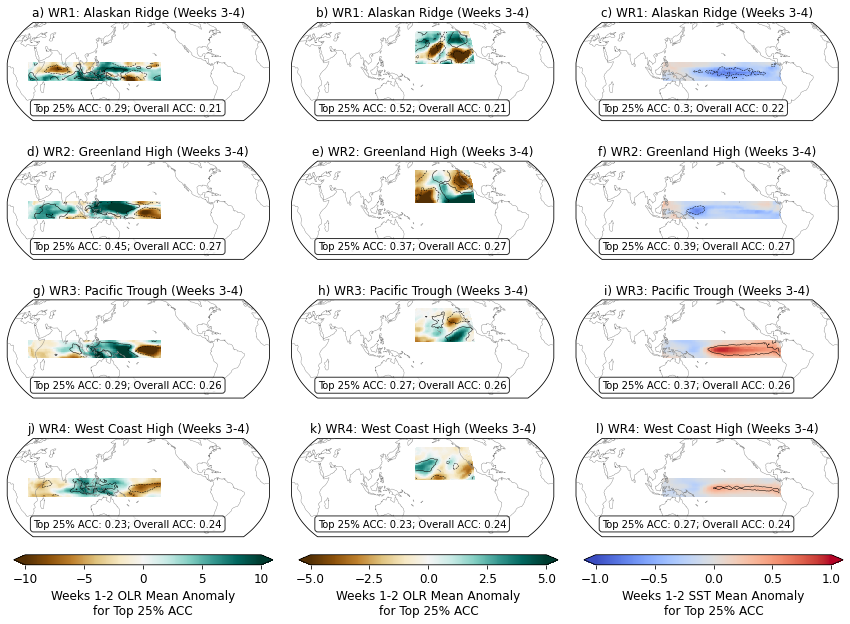

In [58]:
# ---

proj = ccrs.Robinson(central_longitude=180)

fig, axs = plt.subplots(
    4, 3, subplot_kw=dict(projection=proj), figsize=(12, 8))

# ---

pm_tpac = axs[0][0].pcolormesh(
    lons_tpac, lats_tpac, cesm_c0_tpac_1234,
    transform=ccrs.PlateCarree(), vmin=-10, vmax=10, cmap='BrBG')

axs[0][0].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[0][0].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[0][0].contour(
    lons_tpac, lats_tpac, era5_c0_tpac_1234, levels=[-5, 5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[0][0].set_title('a) WR1: Alaskan Ridge (Weeks 3-4)', fontsize=12)
axs[0][0].margins(x=0, y=0)

axs[0][0].annotate(
    f'Top 25% ACC: {np.around(top0_tpac_1234, 2)}; Overall ACC: {np.around(all0_tpac_1234, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8),
    xycoords='axes fraction', zorder=100)


# ---

axs[1][0].pcolormesh(lons_tpac, lats_tpac, cesm_c1_tpac_1234,
                     transform=ccrs.PlateCarree(),
                     vmin=-10, vmax=10, cmap='BrBG')

axs[1][0].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[1][0].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[1][0].contour(
    lons_tpac, lats_tpac, era5_c1_tpac_1234, levels=[-5, 5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[1][0].set_title('d) WR2: Greenland High (Weeks 3-4)', fontsize=12)
axs[1][0].margins(x=0, y=0)

axs[1][0].annotate(
    f'Top 25% ACC: {np.around(top1_tpac_1234, 2)}; Overall ACC: {np.around(all1_tpac_1234, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[2][0].pcolormesh(lons_tpac, lats_tpac, cesm_c2_tpac_1234,
                     transform=ccrs.PlateCarree(),
                     vmin=-10, vmax=10, cmap='BrBG')

axs[2][0].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[2][0].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[2][0].contour(
    lons_tpac, lats_tpac, era5_c2_tpac_1234, levels=[-5, 5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[2][0].set_title('g) WR3: Pacific Trough (Weeks 3-4)', fontsize=12)
axs[2][0].margins(x=0, y=0)

axs[2][0].annotate(
    f'Top 25% ACC: {np.around(top2_tpac_1234, 2)}; Overall ACC: {np.around(all2_tpac_1234, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[3][0].pcolormesh(lons_tpac, lats_tpac, cesm_c3_tpac_1234,
                     transform=ccrs.PlateCarree(),
                     vmin=-10, vmax=10, cmap='BrBG')

axs[3][0].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[3][0].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[3][0].contour(
    lons_tpac, lats_tpac, era5_c3_tpac_1234, levels=[-5, 5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[3][0].set_title('j) WR4: West Coast High (Weeks 3-4)', fontsize=12)
axs[3][0].margins(x=0, y=0)

axs[3][0].annotate(
    f'Top 25% ACC: {np.around(top3_tpac_1234, 2)}; Overall ACC: {np.around(all3_tpac_1234, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

pm_npac = axs[0][1].pcolormesh(
    lons_npac, lats_npac, cesm_c0_npac_1234,
    transform=ccrs.PlateCarree(),
    vmin=-5, vmax=5, cmap='BrBG')

axs[0][1].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[0][1].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[0][1].contour(
    lons_npac, lats_npac, era5_c0_npac_1234, levels=[-2.5, 2.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[0][1].set_title('b) WR1: Alaskan Ridge (Weeks 3-4)', fontsize=12)
axs[0][1].margins(x=0, y=0)

axs[0][1].annotate(
    f'Top 25% ACC: {np.around(top0_npac_1234, 2)}; Overall ACC: {np.around(all0_npac_1234, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[1][1].pcolormesh(lons_npac, lats_npac, cesm_c1_npac_1234,
                     transform=ccrs.PlateCarree(),
                     vmin=-5, vmax=5, cmap='BrBG')

axs[1][1].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[1][1].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[1][1].contour(
    lons_npac, lats_npac, era5_c1_npac_1234, levels=[-2.5, 2.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[1][1].set_title('e) WR2: Greenland High (Weeks 3-4)', fontsize=12)
axs[1][1].margins(x=0, y=0)

axs[1][1].annotate(
    f'Top 25% ACC: {np.around(top1_npac_1234, 2)}; Overall ACC: {np.around(all1_npac_1234, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[2][1].pcolormesh(lons_npac, lats_npac, cesm_c2_npac_1234,
                     transform=ccrs.PlateCarree(),
                     vmin=-5, vmax=5, cmap='BrBG')

axs[2][1].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[2][1].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[2][1].contour(
    lons_npac, lats_npac, era5_c2_npac_1234, levels=[-2.5, 2.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[2][1].set_title('h) WR3: Pacific Trough (Weeks 3-4)', fontsize=12)
axs[2][1].margins(x=0, y=0)

axs[2][1].annotate(
    f'Top 25% ACC: {np.around(top2_npac_1234, 2)}; Overall ACC: {np.around(all2_npac_1234, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[3][1].pcolormesh(lons_npac, lats_npac, cesm_c3_npac_1234,
                     transform=ccrs.PlateCarree(),
                     vmin=-5, vmax=5, cmap='BrBG')

axs[3][1].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[3][1].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[3][1].contour(
    lons_npac, lats_npac, era5_c3_npac_1234, levels=[-2.5, 2.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[3][1].set_title('k) WR4: West Coast High (Weeks 3-4)', fontsize=12)
axs[3][1].margins(x=0, y=0)

axs[3][1].annotate(
    f'Top 25% ACC: {np.around(top3_npac_1234, 2)}; Overall ACC: {np.around(all3_npac_1234, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

pm_sstk = axs[0][2].pcolormesh(
    lons_sstk, lats_sstk, cesm_c0_sstk_1234,
    transform=ccrs.PlateCarree(),
    vmin=-1, vmax=1, cmap='coolwarm')

axs[0][2].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[0][2].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[0][2].contour(
    lons_sstk, lats_sstk, era5_c0_sstk_1234, levels=[-0.5, 0.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[0][2].set_title('c) WR1: Alaskan Ridge (Weeks 3-4)', fontsize=12)
axs[0][2].margins(x=0, y=0)

axs[0][2].annotate(
    f'Top 25% ACC: {np.around(top0_sstk_1234, 2)}; Overall ACC: {np.around(all0_sstk_1234, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[1][2].pcolormesh(lons_sstk, lats_sstk, cesm_c1_sstk_1234,
                     transform=ccrs.PlateCarree(),
                     vmin=-1, vmax=1, cmap='coolwarm')

axs[1][2].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[1][2].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[1][2].contour(
    lons_sstk, lats_sstk, era5_c1_sstk_1234, levels=[-0.5, 0.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[1][2].set_title('f) WR2: Greenland High (Weeks 3-4)', fontsize=12)
axs[1][2].margins(x=0, y=0)

axs[1][2].annotate(
    f'Top 25% ACC: {np.around(top1_sstk_1234, 2)}; Overall ACC: {np.around(all1_sstk_1234, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[2][2].pcolormesh(lons_sstk, lats_sstk, cesm_c2_sstk_1234,
                     transform=ccrs.PlateCarree(),
                     vmin=-1, vmax=1, cmap='coolwarm')

axs[2][2].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[2][2].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[2][2].contour(
    lons_sstk, lats_sstk, era5_c2_sstk_1234, levels=[-0.5, 0.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[2][2].set_title('i) WR3: Pacific Trough (Weeks 3-4)', fontsize=12)
axs[2][2].margins(x=0, y=0)

axs[2][2].annotate(
    f'Top 25% ACC: {np.around(top2_sstk_1234, 2)}; Overall ACC: {np.around(all2_sstk_1234, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[3][2].pcolormesh(lons_sstk, lats_sstk, cesm_c3_sstk_1234,
                     transform=ccrs.PlateCarree(),
                     vmin=-1, vmax=1, cmap='coolwarm')

axs[3][2].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[3][2].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[3][2].contour(
    lons_sstk, lats_sstk, era5_c3_sstk_1234, levels=[-0.5, 0.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[3][2].set_title('l) WR4: West Coast High (Weeks 3-4)', fontsize=12)
axs[3][2].margins(x=0, y=0)

axs[3][2].annotate(
    f'Top 25% ACC: {np.around(top3_sstk_1234, 2)}; Overall ACC: {np.around(all3_sstk_1234, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

cbar_ax = fig.add_axes([0.02, 0.0, 0.3, 0.0175])
cbar = fig.colorbar(pm_tpac, cax=cbar_ax, ticks=[-10, -5, 0, 5, 10],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Weeks 1-2 OLR Mean Anomaly\nfor Top 25% ACC', fontsize=12)

cbar_ax = fig.add_axes([0.35, 0.0, 0.3, 0.0175])
cbar = fig.colorbar(pm_npac, cax=cbar_ax, ticks=[-5, -2.5, 0, 2.5, 5],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Weeks 1-2 OLR Mean Anomaly\nfor Top 25% ACC', fontsize=12)

cbar_ax = fig.add_axes([0.68, 0.0, 0.3, 0.0175])
cbar = fig.colorbar(pm_sstk, cax=cbar_ax, ticks=[-1, -0.5, 0, 0.5, 1],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Weeks 1-2 SST Mean Anomaly\nfor Top 25% ACC', fontsize=12)

# ---

plt.tight_layout()
plt.savefig("fig_week1234.png", bbox_inches='tight', dpi=500)
plt.show()

# ---

/glade/scratch/molina/ipykernel_128702/3893936709.py:357: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


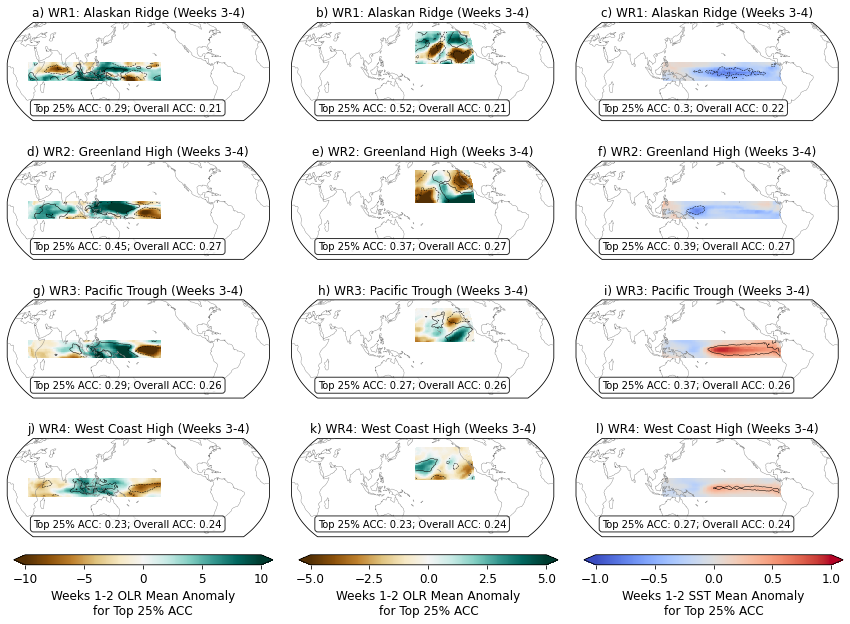

In [59]:
# ---

proj = ccrs.Robinson(central_longitude=180)

fig, axs = plt.subplots(
    4, 3, subplot_kw=dict(projection=proj), figsize=(12, 8))

# ---

pm_tpac = axs[0][0].pcolormesh(
    lons_tpac, lats_tpac, cesm_c0_tpac_1234,
    transform=ccrs.PlateCarree(), vmin=-10, vmax=10, cmap='BrBG')

axs[0][0].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[0][0].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[0][0].contour(
    lons_tpac, lats_tpac, era5_c0_tpac_1234, levels=[-5, 5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[0][0].set_title('a) WR1: Alaskan Ridge (Weeks 3-4)', fontsize=12)
axs[0][0].margins(x=0, y=0)

axs[0][0].annotate(
    f'Top 25% ACC: {np.around(top0_tpac_1234, 2)}; Overall ACC: {np.around(all0_tpac_1234, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8),
    xycoords='axes fraction', zorder=100)


# ---

axs[1][0].pcolormesh(lons_tpac, lats_tpac, cesm_c1_tpac_1234,
                     transform=ccrs.PlateCarree(),
                     vmin=-10, vmax=10, cmap='BrBG')

axs[1][0].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[1][0].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[1][0].contour(
    lons_tpac, lats_tpac, era5_c1_tpac_1234, levels=[-5, 5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[1][0].set_title('d) WR2: Greenland High (Weeks 3-4)', fontsize=12)
axs[1][0].margins(x=0, y=0)

axs[1][0].annotate(
    f'Top 25% ACC: {np.around(top1_tpac_1234, 2)}; Overall ACC: {np.around(all1_tpac_1234, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[2][0].pcolormesh(lons_tpac, lats_tpac, cesm_c2_tpac_1234,
                     transform=ccrs.PlateCarree(),
                     vmin=-10, vmax=10, cmap='BrBG')

axs[2][0].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[2][0].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[2][0].contour(
    lons_tpac, lats_tpac, era5_c2_tpac_1234, levels=[-5, 5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[2][0].set_title('g) WR3: Pacific Trough (Weeks 3-4)', fontsize=12)
axs[2][0].margins(x=0, y=0)

axs[2][0].annotate(
    f'Top 25% ACC: {np.around(top2_tpac_1234, 2)}; Overall ACC: {np.around(all2_tpac_1234, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[3][0].pcolormesh(lons_tpac, lats_tpac, cesm_c3_tpac_1234,
                     transform=ccrs.PlateCarree(),
                     vmin=-10, vmax=10, cmap='BrBG')

axs[3][0].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[3][0].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[3][0].contour(
    lons_tpac, lats_tpac, era5_c3_tpac_1234, levels=[-5, 5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[3][0].set_title('j) WR4: West Coast High (Weeks 3-4)', fontsize=12)
axs[3][0].margins(x=0, y=0)

axs[3][0].annotate(
    f'Top 25% ACC: {np.around(top3_tpac_1234, 2)}; Overall ACC: {np.around(all3_tpac_1234, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

pm_npac = axs[0][1].pcolormesh(
    lons_npac, lats_npac, cesm_c0_npac_1234,
    transform=ccrs.PlateCarree(),
    vmin=-5, vmax=5, cmap='BrBG')

axs[0][1].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[0][1].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[0][1].contour(
    lons_npac, lats_npac, era5_c0_npac_1234, levels=[-2.5, 2.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[0][1].set_title('b) WR1: Alaskan Ridge (Weeks 3-4)', fontsize=12)
axs[0][1].margins(x=0, y=0)

axs[0][1].annotate(
    f'Top 25% ACC: {np.around(top0_npac_1234, 2)}; Overall ACC: {np.around(all0_npac_1234, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[1][1].pcolormesh(lons_npac, lats_npac, cesm_c1_npac_1234,
                     transform=ccrs.PlateCarree(),
                     vmin=-5, vmax=5, cmap='BrBG')

axs[1][1].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[1][1].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[1][1].contour(
    lons_npac, lats_npac, era5_c1_npac_1234, levels=[-2.5, 2.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[1][1].set_title('e) WR2: Greenland High (Weeks 3-4)', fontsize=12)
axs[1][1].margins(x=0, y=0)

axs[1][1].annotate(
    f'Top 25% ACC: {np.around(top1_npac_1234, 2)}; Overall ACC: {np.around(all1_npac_1234, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[2][1].pcolormesh(lons_npac, lats_npac, cesm_c2_npac_1234,
                     transform=ccrs.PlateCarree(),
                     vmin=-5, vmax=5, cmap='BrBG')

axs[2][1].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[2][1].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[2][1].contour(
    lons_npac, lats_npac, era5_c2_npac_1234, levels=[-2.5, 2.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[2][1].set_title('h) WR3: Pacific Trough (Weeks 3-4)', fontsize=12)
axs[2][1].margins(x=0, y=0)

axs[2][1].annotate(
    f'Top 25% ACC: {np.around(top2_npac_1234, 2)}; Overall ACC: {np.around(all2_npac_1234, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[3][1].pcolormesh(lons_npac, lats_npac, cesm_c3_npac_1234,
                     transform=ccrs.PlateCarree(),
                     vmin=-5, vmax=5, cmap='BrBG')

axs[3][1].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[3][1].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[3][1].contour(
    lons_npac, lats_npac, era5_c3_npac_1234, levels=[-2.5, 2.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[3][1].set_title('k) WR4: West Coast High (Weeks 3-4)', fontsize=12)
axs[3][1].margins(x=0, y=0)

axs[3][1].annotate(
    f'Top 25% ACC: {np.around(top3_npac_1234, 2)}; Overall ACC: {np.around(all3_npac_1234, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

pm_sstk = axs[0][2].pcolormesh(
    lons_sstk, lats_sstk, cesm_c0_sstk_1234,
    transform=ccrs.PlateCarree(),
    vmin=-1, vmax=1, cmap='coolwarm')

axs[0][2].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[0][2].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[0][2].contour(
    lons_sstk, lats_sstk, era5_c0_sstk_1234, levels=[-0.5, 0.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[0][2].set_title('c) WR1: Alaskan Ridge (Weeks 3-4)', fontsize=12)
axs[0][2].margins(x=0, y=0)

axs[0][2].annotate(
    f'Top 25% ACC: {np.around(top0_sstk_1234, 2)}; Overall ACC: {np.around(all0_sstk_1234, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[1][2].pcolormesh(lons_sstk, lats_sstk, cesm_c1_sstk_1234,
                     transform=ccrs.PlateCarree(),
                     vmin=-1, vmax=1, cmap='coolwarm')

axs[1][2].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[1][2].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[1][2].contour(
    lons_sstk, lats_sstk, era5_c1_sstk_1234, levels=[-0.5, 0.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[1][2].set_title('f) WR2: Greenland High (Weeks 3-4)', fontsize=12)
axs[1][2].margins(x=0, y=0)

axs[1][2].annotate(
    f'Top 25% ACC: {np.around(top1_sstk_1234, 2)}; Overall ACC: {np.around(all1_sstk_1234, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[2][2].pcolormesh(lons_sstk, lats_sstk, cesm_c2_sstk_1234,
                     transform=ccrs.PlateCarree(),
                     vmin=-1, vmax=1, cmap='coolwarm')

axs[2][2].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[2][2].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[2][2].contour(
    lons_sstk, lats_sstk, era5_c2_sstk_1234, levels=[-0.5, 0.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[2][2].set_title('i) WR3: Pacific Trough (Weeks 3-4)', fontsize=12)
axs[2][2].margins(x=0, y=0)

axs[2][2].annotate(
    f'Top 25% ACC: {np.around(top2_sstk_1234, 2)}; Overall ACC: {np.around(all2_sstk_1234, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[3][2].pcolormesh(lons_sstk, lats_sstk, cesm_c3_sstk_1234,
                     transform=ccrs.PlateCarree(),
                     vmin=-1, vmax=1, cmap='coolwarm')

axs[3][2].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[3][2].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[3][2].contour(
    lons_sstk, lats_sstk, era5_c3_sstk_1234, levels=[-0.5, 0.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[3][2].set_title('l) WR4: West Coast High (Weeks 3-4)', fontsize=12)
axs[3][2].margins(x=0, y=0)

axs[3][2].annotate(
    f'Top 25% ACC: {np.around(top3_sstk_1234, 2)}; Overall ACC: {np.around(all3_sstk_1234, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

cbar_ax = fig.add_axes([0.02, 0.0, 0.3, 0.0175])
cbar = fig.colorbar(pm_tpac, cax=cbar_ax, ticks=[-10, -5, 0, 5, 10],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Weeks 1-2 OLR Mean Anomaly\nfor Top 25% ACC', fontsize=12)

cbar_ax = fig.add_axes([0.35, 0.0, 0.3, 0.0175])
cbar = fig.colorbar(pm_npac, cax=cbar_ax, ticks=[-5, -2.5, 0, 2.5, 5],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Weeks 1-2 OLR Mean Anomaly\nfor Top 25% ACC', fontsize=12)

cbar_ax = fig.add_axes([0.68, 0.0, 0.3, 0.0175])
cbar = fig.colorbar(pm_sstk, cax=cbar_ax, ticks=[-1, -0.5, 0, 0.5, 1],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Weeks 1-2 SST Mean Anomaly\nfor Top 25% ACC', fontsize=12)

# ---

plt.tight_layout()
plt.savefig("fig_week1234.pdf", bbox_inches='tight')
plt.show()

# ---

/glade/work/molina/miniconda3/envs/myenv-tfgpu/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1548: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/glade/scratch/molina/ipykernel_128702/1393258251.py:356: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


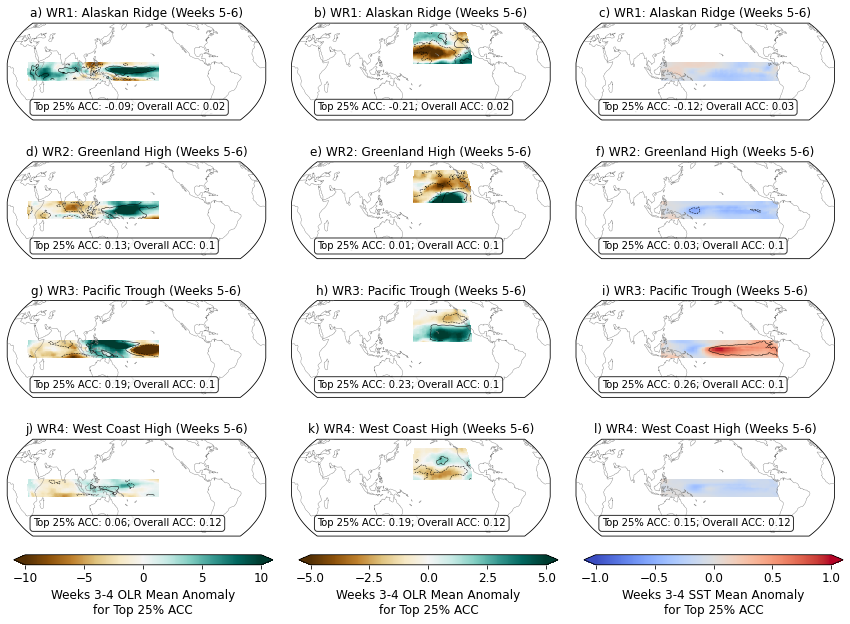

In [60]:
# ---

proj = ccrs.Robinson(central_longitude=180)

fig, axs = plt.subplots(
    4, 3, subplot_kw=dict(projection=proj), figsize=(12, 8))

# ---

pm_tpac = axs[0][0].pcolormesh(
    lons_tpac, lats_tpac, cesm_c0_tpac_3456,
    transform=ccrs.PlateCarree(), vmin=-10, vmax=10, cmap='BrBG')

axs[0][0].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[0][0].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[0][0].contour(
    lons_tpac, lats_tpac, era5_c0_tpac_3456, levels=[-5, 5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[0][0].set_title('a) WR1: Alaskan Ridge (Weeks 5-6)', fontsize=12)
axs[0][0].margins(x=0, y=0)

axs[0][0].annotate(
    f'Top 25% ACC: {np.around(top0_tpac_3456, 2)}; Overall ACC: {np.around(all0_tpac_3456, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8),
    xycoords='axes fraction', zorder=100)

# ---

axs[1][0].pcolormesh(lons_tpac, lats_tpac, cesm_c1_tpac_3456,
                     transform=ccrs.PlateCarree(),
                     vmin=-10, vmax=10, cmap='BrBG')

axs[1][0].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[1][0].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[1][0].contour(
    lons_tpac, lats_tpac, era5_c1_tpac_3456, levels=[-5, 5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[1][0].set_title('d) WR2: Greenland High (Weeks 5-6)', fontsize=12)
axs[1][0].margins(x=0, y=0)

axs[1][0].annotate(
    f'Top 25% ACC: {np.around(top1_tpac_3456, 2)}; Overall ACC: {np.around(all1_tpac_3456, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[2][0].pcolormesh(lons_tpac, lats_tpac, cesm_c2_tpac_3456,
                     transform=ccrs.PlateCarree(),
                     vmin=-10, vmax=10, cmap='BrBG')

axs[2][0].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[2][0].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[2][0].contour(
    lons_tpac, lats_tpac, era5_c2_tpac_3456, levels=[-5, 5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[2][0].set_title('g) WR3: Pacific Trough (Weeks 5-6)', fontsize=12)
axs[2][0].margins(x=0, y=0)

axs[2][0].annotate(
    f'Top 25% ACC: {np.around(top2_tpac_3456, 2)}; Overall ACC: {np.around(all2_tpac_3456, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[3][0].pcolormesh(lons_tpac, lats_tpac, cesm_c3_tpac_3456,
                     transform=ccrs.PlateCarree(),
                     vmin=-10, vmax=10, cmap='BrBG')

axs[3][0].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[3][0].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[3][0].contour(
    lons_tpac, lats_tpac, era5_c3_tpac_3456, levels=[-5, 5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[3][0].set_title('j) WR4: West Coast High (Weeks 5-6)', fontsize=12)
axs[3][0].margins(x=0, y=0)

axs[3][0].annotate(
    f'Top 25% ACC: {np.around(top3_tpac_3456, 2)}; Overall ACC: {np.around(all3_tpac_3456, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

pm_npac = axs[0][1].pcolormesh(
    lons_npac, lats_npac, cesm_c0_npac_3456,
    transform=ccrs.PlateCarree(),
    vmin=-5, vmax=5, cmap='BrBG')

axs[0][1].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[0][1].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[0][1].contour(
    lons_npac, lats_npac, era5_c0_npac_3456, levels=[-2.5, 2.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[0][1].set_title('b) WR1: Alaskan Ridge (Weeks 5-6)', fontsize=12)
axs[0][1].margins(x=0, y=0)

axs[0][1].annotate(
    f'Top 25% ACC: {np.around(top0_npac_3456, 2)}; Overall ACC: {np.around(all0_npac_3456, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[1][1].pcolormesh(lons_npac, lats_npac, cesm_c1_npac_3456,
                     transform=ccrs.PlateCarree(),
                     vmin=-5, vmax=5, cmap='BrBG')

axs[1][1].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[1][1].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[1][1].contour(
    lons_npac, lats_npac, era5_c1_npac_3456, levels=[-2.5, 2.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[1][1].set_title('e) WR2: Greenland High (Weeks 5-6)', fontsize=12)
axs[1][1].margins(x=0, y=0)

axs[1][1].annotate(
    f'Top 25% ACC: {np.around(top1_npac_3456, 2)}; Overall ACC: {np.around(all1_npac_3456, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[2][1].pcolormesh(lons_npac, lats_npac, cesm_c2_npac_3456,
                     transform=ccrs.PlateCarree(),
                     vmin=-5, vmax=5, cmap='BrBG')

axs[2][1].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[2][1].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[2][1].contour(
    lons_npac, lats_npac, era5_c2_npac_3456, levels=[-2.5, 2.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[2][1].set_title('h) WR3: Pacific Trough (Weeks 5-6)', fontsize=12)
axs[2][1].margins(x=0, y=0)

axs[2][1].annotate(
    f'Top 25% ACC: {np.around(top2_npac_3456, 2)}; Overall ACC: {np.around(all2_npac_3456, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[3][1].pcolormesh(lons_npac, lats_npac, cesm_c3_npac_3456,
                     transform=ccrs.PlateCarree(),
                     vmin=-5, vmax=5, cmap='BrBG')

axs[3][1].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[3][1].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[3][1].contour(
    lons_npac, lats_npac, era5_c3_npac_3456, levels=[-2.5, 2.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[3][1].set_title('k) WR4: West Coast High (Weeks 5-6)', fontsize=12)
axs[3][1].margins(x=0, y=0)

axs[3][1].annotate(
    f'Top 25% ACC: {np.around(top3_npac_3456, 2)}; Overall ACC: {np.around(all3_npac_3456, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

pm_sstk = axs[0][2].pcolormesh(
    lons_sstk, lats_sstk, cesm_c0_sstk_3456,
    transform=ccrs.PlateCarree(),
    vmin=-1, vmax=1, cmap='coolwarm')

axs[0][2].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[0][2].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[0][2].contour(
    lons_sstk, lats_sstk, era5_c0_sstk_3456, levels=[-0.5, 0.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[0][2].set_title('c) WR1: Alaskan Ridge (Weeks 5-6)', fontsize=12)
axs[0][2].margins(x=0, y=0)

axs[0][2].annotate(
    f'Top 25% ACC: {np.around(top0_sstk_3456, 2)}; Overall ACC: {np.around(all0_sstk_3456, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[1][2].pcolormesh(lons_sstk, lats_sstk, cesm_c1_sstk_3456,
                     transform=ccrs.PlateCarree(),
                     vmin=-1, vmax=1, cmap='coolwarm')

axs[1][2].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[1][2].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[1][2].contour(
    lons_sstk, lats_sstk, era5_c1_sstk_3456, levels=[-0.5, 0.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[1][2].set_title('f) WR2: Greenland High (Weeks 5-6)', fontsize=12)
axs[1][2].margins(x=0, y=0)

axs[1][2].annotate(
    f'Top 25% ACC: {np.around(top1_sstk_3456, 2)}; Overall ACC: {np.around(all1_sstk_3456, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[2][2].pcolormesh(lons_sstk, lats_sstk, cesm_c2_sstk_3456,
                     transform=ccrs.PlateCarree(),
                     vmin=-1, vmax=1, cmap='coolwarm')

axs[2][2].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[2][2].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[2][2].contour(
    lons_sstk, lats_sstk, era5_c2_sstk_3456, levels=[-0.5, 0.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[2][2].set_title('i) WR3: Pacific Trough (Weeks 5-6)', fontsize=12)
axs[2][2].margins(x=0, y=0)

axs[2][2].annotate(
    f'Top 25% ACC: {np.around(top2_sstk_3456, 2)}; Overall ACC: {np.around(all2_sstk_3456, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[3][2].pcolormesh(lons_sstk, lats_sstk, cesm_c3_sstk_3456,
                     transform=ccrs.PlateCarree(),
                     vmin=-1, vmax=1, cmap='coolwarm')

axs[3][2].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[3][2].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[3][2].contour(
    lons_sstk, lats_sstk, era5_c3_sstk_3456, levels=[-0.5, 0.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[3][2].set_title('l) WR4: West Coast High (Weeks 5-6)', fontsize=12)
axs[3][2].margins(x=0, y=0)

axs[3][2].annotate(
    f'Top 25% ACC: {np.around(top3_sstk_3456, 2)}; Overall ACC: {np.around(all3_sstk_3456, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

cbar_ax = fig.add_axes([0.02, 0.0, 0.3, 0.0175])
cbar = fig.colorbar(pm_tpac, cax=cbar_ax, ticks=[-10, -5, 0, 5, 10],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Weeks 3-4 OLR Mean Anomaly\nfor Top 25% ACC', fontsize=12)

cbar_ax = fig.add_axes([0.35, 0.0, 0.3, 0.0175])
cbar = fig.colorbar(pm_npac, cax=cbar_ax, ticks=[-5, -2.5, 0, 2.5, 5],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Weeks 3-4 OLR Mean Anomaly\nfor Top 25% ACC', fontsize=12)

cbar_ax = fig.add_axes([0.68, 0.0, 0.3, 0.0175])
cbar = fig.colorbar(pm_sstk, cax=cbar_ax, ticks=[-1, -0.5, 0, 0.5, 1],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Weeks 3-4 SST Mean Anomaly\nfor Top 25% ACC', fontsize=12)

# ---

plt.tight_layout()
plt.savefig("fig_week3456.png", bbox_inches='tight', dpi=500)
plt.show()

# ---

/glade/scratch/molina/ipykernel_128702/4095857614.py:356: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


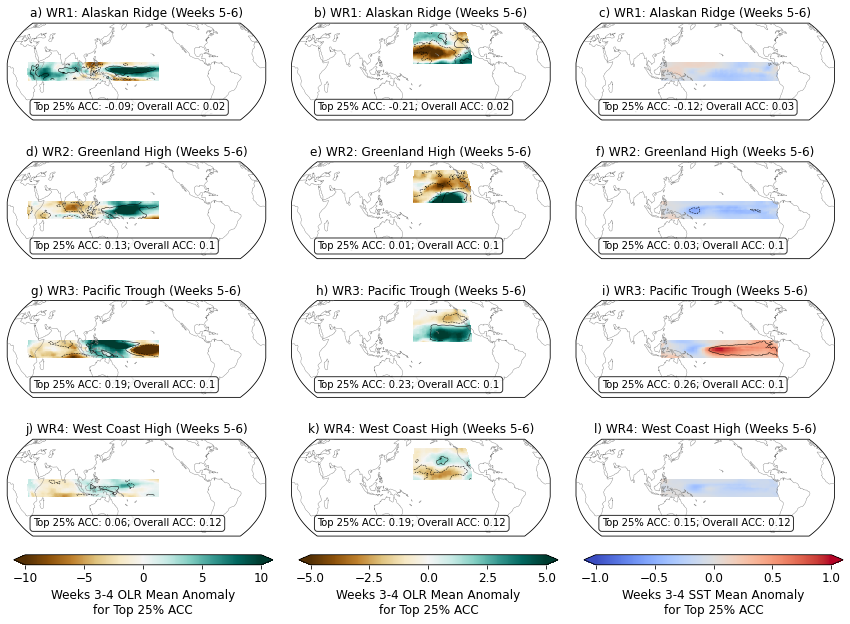

In [61]:
# ---

proj = ccrs.Robinson(central_longitude=180)

fig, axs = plt.subplots(
    4, 3, subplot_kw=dict(projection=proj), figsize=(12, 8))

# ---

pm_tpac = axs[0][0].pcolormesh(
    lons_tpac, lats_tpac, cesm_c0_tpac_3456,
    transform=ccrs.PlateCarree(), vmin=-10, vmax=10, cmap='BrBG')

axs[0][0].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[0][0].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[0][0].contour(
    lons_tpac, lats_tpac, era5_c0_tpac_3456, levels=[-5, 5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[0][0].set_title('a) WR1: Alaskan Ridge (Weeks 5-6)', fontsize=12)
axs[0][0].margins(x=0, y=0)

axs[0][0].annotate(
    f'Top 25% ACC: {np.around(top0_tpac_3456, 2)}; Overall ACC: {np.around(all0_tpac_3456, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8),
    xycoords='axes fraction', zorder=100)

# ---

axs[1][0].pcolormesh(lons_tpac, lats_tpac, cesm_c1_tpac_3456,
                     transform=ccrs.PlateCarree(),
                     vmin=-10, vmax=10, cmap='BrBG')

axs[1][0].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[1][0].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[1][0].contour(
    lons_tpac, lats_tpac, era5_c1_tpac_3456, levels=[-5, 5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[1][0].set_title('d) WR2: Greenland High (Weeks 5-6)', fontsize=12)
axs[1][0].margins(x=0, y=0)

axs[1][0].annotate(
    f'Top 25% ACC: {np.around(top1_tpac_3456, 2)}; Overall ACC: {np.around(all1_tpac_3456, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[2][0].pcolormesh(lons_tpac, lats_tpac, cesm_c2_tpac_3456,
                     transform=ccrs.PlateCarree(),
                     vmin=-10, vmax=10, cmap='BrBG')

axs[2][0].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[2][0].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[2][0].contour(
    lons_tpac, lats_tpac, era5_c2_tpac_3456, levels=[-5, 5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[2][0].set_title('g) WR3: Pacific Trough (Weeks 5-6)', fontsize=12)
axs[2][0].margins(x=0, y=0)

axs[2][0].annotate(
    f'Top 25% ACC: {np.around(top2_tpac_3456, 2)}; Overall ACC: {np.around(all2_tpac_3456, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[3][0].pcolormesh(lons_tpac, lats_tpac, cesm_c3_tpac_3456,
                     transform=ccrs.PlateCarree(),
                     vmin=-10, vmax=10, cmap='BrBG')

axs[3][0].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[3][0].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[3][0].contour(
    lons_tpac, lats_tpac, era5_c3_tpac_3456, levels=[-5, 5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[3][0].set_title('j) WR4: West Coast High (Weeks 5-6)', fontsize=12)
axs[3][0].margins(x=0, y=0)

axs[3][0].annotate(
    f'Top 25% ACC: {np.around(top3_tpac_3456, 2)}; Overall ACC: {np.around(all3_tpac_3456, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

pm_npac = axs[0][1].pcolormesh(
    lons_npac, lats_npac, cesm_c0_npac_3456,
    transform=ccrs.PlateCarree(),
    vmin=-5, vmax=5, cmap='BrBG')

axs[0][1].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[0][1].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[0][1].contour(
    lons_npac, lats_npac, era5_c0_npac_3456, levels=[-2.5, 2.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[0][1].set_title('b) WR1: Alaskan Ridge (Weeks 5-6)', fontsize=12)
axs[0][1].margins(x=0, y=0)

axs[0][1].annotate(
    f'Top 25% ACC: {np.around(top0_npac_3456, 2)}; Overall ACC: {np.around(all0_npac_3456, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[1][1].pcolormesh(lons_npac, lats_npac, cesm_c1_npac_3456,
                     transform=ccrs.PlateCarree(),
                     vmin=-5, vmax=5, cmap='BrBG')

axs[1][1].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[1][1].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[1][1].contour(
    lons_npac, lats_npac, era5_c1_npac_3456, levels=[-2.5, 2.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[1][1].set_title('e) WR2: Greenland High (Weeks 5-6)', fontsize=12)
axs[1][1].margins(x=0, y=0)

axs[1][1].annotate(
    f'Top 25% ACC: {np.around(top1_npac_3456, 2)}; Overall ACC: {np.around(all1_npac_3456, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[2][1].pcolormesh(lons_npac, lats_npac, cesm_c2_npac_3456,
                     transform=ccrs.PlateCarree(),
                     vmin=-5, vmax=5, cmap='BrBG')

axs[2][1].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[2][1].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[2][1].contour(
    lons_npac, lats_npac, era5_c2_npac_3456, levels=[-2.5, 2.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[2][1].set_title('h) WR3: Pacific Trough (Weeks 5-6)', fontsize=12)
axs[2][1].margins(x=0, y=0)

axs[2][1].annotate(
    f'Top 25% ACC: {np.around(top2_npac_3456, 2)}; Overall ACC: {np.around(all2_npac_3456, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[3][1].pcolormesh(lons_npac, lats_npac, cesm_c3_npac_3456,
                     transform=ccrs.PlateCarree(),
                     vmin=-5, vmax=5, cmap='BrBG')

axs[3][1].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[3][1].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[3][1].contour(
    lons_npac, lats_npac, era5_c3_npac_3456, levels=[-2.5, 2.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[3][1].set_title('k) WR4: West Coast High (Weeks 5-6)', fontsize=12)
axs[3][1].margins(x=0, y=0)

axs[3][1].annotate(
    f'Top 25% ACC: {np.around(top3_npac_3456, 2)}; Overall ACC: {np.around(all3_npac_3456, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

pm_sstk = axs[0][2].pcolormesh(
    lons_sstk, lats_sstk, cesm_c0_sstk_3456,
    transform=ccrs.PlateCarree(),
    vmin=-1, vmax=1, cmap='coolwarm')

axs[0][2].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[0][2].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[0][2].contour(
    lons_sstk, lats_sstk, era5_c0_sstk_3456, levels=[-0.5, 0.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[0][2].set_title('c) WR1: Alaskan Ridge (Weeks 5-6)', fontsize=12)
axs[0][2].margins(x=0, y=0)

axs[0][2].annotate(
    f'Top 25% ACC: {np.around(top0_sstk_3456, 2)}; Overall ACC: {np.around(all0_sstk_3456, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[1][2].pcolormesh(lons_sstk, lats_sstk, cesm_c1_sstk_3456,
                     transform=ccrs.PlateCarree(),
                     vmin=-1, vmax=1, cmap='coolwarm')

axs[1][2].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[1][2].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[1][2].contour(
    lons_sstk, lats_sstk, era5_c1_sstk_3456, levels=[-0.5, 0.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[1][2].set_title('f) WR2: Greenland High (Weeks 5-6)', fontsize=12)
axs[1][2].margins(x=0, y=0)

axs[1][2].annotate(
    f'Top 25% ACC: {np.around(top1_sstk_3456, 2)}; Overall ACC: {np.around(all1_sstk_3456, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[2][2].pcolormesh(lons_sstk, lats_sstk, cesm_c2_sstk_3456,
                     transform=ccrs.PlateCarree(),
                     vmin=-1, vmax=1, cmap='coolwarm')

axs[2][2].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[2][2].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[2][2].contour(
    lons_sstk, lats_sstk, era5_c2_sstk_3456, levels=[-0.5, 0.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[2][2].set_title('i) WR3: Pacific Trough (Weeks 5-6)', fontsize=12)
axs[2][2].margins(x=0, y=0)

axs[2][2].annotate(
    f'Top 25% ACC: {np.around(top2_sstk_3456, 2)}; Overall ACC: {np.around(all2_sstk_3456, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[3][2].pcolormesh(lons_sstk, lats_sstk, cesm_c3_sstk_3456,
                     transform=ccrs.PlateCarree(),
                     vmin=-1, vmax=1, cmap='coolwarm')

axs[3][2].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[3][2].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[3][2].contour(
    lons_sstk, lats_sstk, era5_c3_sstk_3456, levels=[-0.5, 0.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[3][2].set_title('l) WR4: West Coast High (Weeks 5-6)', fontsize=12)
axs[3][2].margins(x=0, y=0)

axs[3][2].annotate(
    f'Top 25% ACC: {np.around(top3_sstk_3456, 2)}; Overall ACC: {np.around(all3_sstk_3456, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

cbar_ax = fig.add_axes([0.02, 0.0, 0.3, 0.0175])
cbar = fig.colorbar(pm_tpac, cax=cbar_ax, ticks=[-10, -5, 0, 5, 10],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Weeks 3-4 OLR Mean Anomaly\nfor Top 25% ACC', fontsize=12)

cbar_ax = fig.add_axes([0.35, 0.0, 0.3, 0.0175])
cbar = fig.colorbar(pm_npac, cax=cbar_ax, ticks=[-5, -2.5, 0, 2.5, 5],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Weeks 3-4 OLR Mean Anomaly\nfor Top 25% ACC', fontsize=12)

cbar_ax = fig.add_axes([0.68, 0.0, 0.3, 0.0175])
cbar = fig.colorbar(pm_sstk, cax=cbar_ax, ticks=[-1, -0.5, 0, 0.5, 1],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Weeks 3-4 SST Mean Anomaly\nfor Top 25% ACC', fontsize=12)

# ---

plt.tight_layout()
plt.savefig("fig_week3456.pdf", bbox_inches='tight')
plt.show()

# ---

/glade/work/molina/miniconda3/envs/myenv-tfgpu/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1548: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/glade/scratch/molina/ipykernel_128702/2930409677.py:357: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


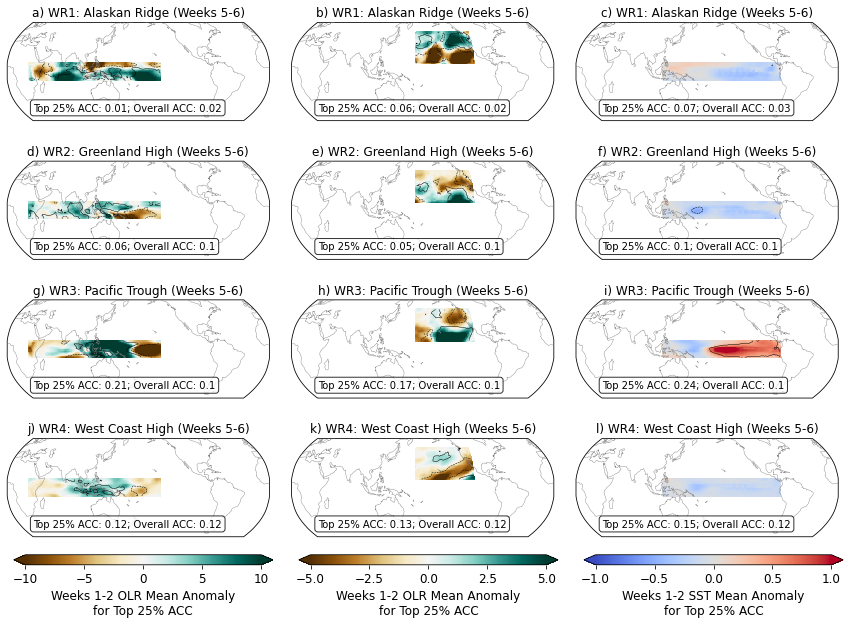

In [62]:
# ---

proj = ccrs.Robinson(central_longitude=180)

fig, axs = plt.subplots(
    4, 3, subplot_kw=dict(projection=proj), figsize=(12, 8))

# ---

pm_tpac = axs[0][0].pcolormesh(
    lons_tpac, lats_tpac, cesm_c0_tpac_1256,
    transform=ccrs.PlateCarree(), vmin=-10, vmax=10, cmap='BrBG')

axs[0][0].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[0][0].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[0][0].contour(
    lons_tpac, lats_tpac, era5_c0_tpac_1256, levels=[-5, 5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[0][0].set_title('a) WR1: Alaskan Ridge (Weeks 5-6)', fontsize=12)
axs[0][0].margins(x=0, y=0)

axs[0][0].annotate(
    f'Top 25% ACC: {np.around(top0_tpac_1256, 2)}; Overall ACC: {np.around(all0_tpac_1256, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8),
    xycoords='axes fraction', zorder=100)


# ---

axs[1][0].pcolormesh(lons_tpac, lats_tpac, cesm_c1_tpac_1256,
                     transform=ccrs.PlateCarree(),
                     vmin=-10, vmax=10, cmap='BrBG')

axs[1][0].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[1][0].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[1][0].contour(
    lons_tpac, lats_tpac, era5_c1_tpac_1256, levels=[-5, 5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[1][0].set_title('d) WR2: Greenland High (Weeks 5-6)', fontsize=12)
axs[1][0].margins(x=0, y=0)

axs[1][0].annotate(
    f'Top 25% ACC: {np.around(top1_tpac_1256, 2)}; Overall ACC: {np.around(all1_tpac_1256, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[2][0].pcolormesh(lons_tpac, lats_tpac, cesm_c2_tpac_1256,
                     transform=ccrs.PlateCarree(),
                     vmin=-10, vmax=10, cmap='BrBG')

axs[2][0].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[2][0].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[2][0].contour(
    lons_tpac, lats_tpac, era5_c2_tpac_1256, levels=[-5, 5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[2][0].set_title('g) WR3: Pacific Trough (Weeks 5-6)', fontsize=12)
axs[2][0].margins(x=0, y=0)

axs[2][0].annotate(
    f'Top 25% ACC: {np.around(top2_tpac_1256, 2)}; Overall ACC: {np.around(all2_tpac_1256, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[3][0].pcolormesh(lons_tpac, lats_tpac, cesm_c3_tpac_1256,
                     transform=ccrs.PlateCarree(),
                     vmin=-10, vmax=10, cmap='BrBG')

axs[3][0].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[3][0].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[3][0].contour(
    lons_tpac, lats_tpac, era5_c3_tpac_1256, levels=[-5, 5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[3][0].set_title('j) WR4: West Coast High (Weeks 5-6)', fontsize=12)
axs[3][0].margins(x=0, y=0)

axs[3][0].annotate(
    f'Top 25% ACC: {np.around(top3_tpac_1256, 2)}; Overall ACC: {np.around(all3_tpac_1256, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

pm_npac = axs[0][1].pcolormesh(
    lons_npac, lats_npac, cesm_c0_npac_1256,
    transform=ccrs.PlateCarree(),
    vmin=-5, vmax=5, cmap='BrBG')

axs[0][1].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[0][1].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[0][1].contour(
    lons_npac, lats_npac, era5_c0_npac_1256, levels=[-2.5, 2.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[0][1].set_title('b) WR1: Alaskan Ridge (Weeks 5-6)', fontsize=12)
axs[0][1].margins(x=0, y=0)

axs[0][1].annotate(
    f'Top 25% ACC: {np.around(top0_npac_1256, 2)}; Overall ACC: {np.around(all0_npac_1256, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[1][1].pcolormesh(lons_npac, lats_npac, cesm_c1_npac_1256,
                     transform=ccrs.PlateCarree(),
                     vmin=-5, vmax=5, cmap='BrBG')

axs[1][1].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[1][1].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[1][1].contour(
    lons_npac, lats_npac, era5_c1_npac_1256, levels=[-2.5, 2.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[1][1].set_title('e) WR2: Greenland High (Weeks 5-6)', fontsize=12)
axs[1][1].margins(x=0, y=0)

axs[1][1].annotate(
    f'Top 25% ACC: {np.around(top1_npac_1256, 2)}; Overall ACC: {np.around(all1_npac_1256, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[2][1].pcolormesh(lons_npac, lats_npac, cesm_c2_npac_1256,
                     transform=ccrs.PlateCarree(),
                     vmin=-5, vmax=5, cmap='BrBG')

axs[2][1].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[2][1].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[2][1].contour(
    lons_npac, lats_npac, era5_c2_npac_1256, levels=[-2.5, 2.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[2][1].set_title('h) WR3: Pacific Trough (Weeks 5-6)', fontsize=12)
axs[2][1].margins(x=0, y=0)

axs[2][1].annotate(
    f'Top 25% ACC: {np.around(top2_npac_1256, 2)}; Overall ACC: {np.around(all2_npac_1256, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[3][1].pcolormesh(lons_npac, lats_npac, cesm_c3_npac_1256,
                     transform=ccrs.PlateCarree(),
                     vmin=-5, vmax=5, cmap='BrBG')

axs[3][1].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[3][1].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[3][1].contour(
    lons_npac, lats_npac, era5_c3_npac_1256, levels=[-2.5, 2.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[3][1].set_title('k) WR4: West Coast High (Weeks 5-6)', fontsize=12)
axs[3][1].margins(x=0, y=0)

axs[3][1].annotate(
    f'Top 25% ACC: {np.around(top3_npac_1256, 2)}; Overall ACC: {np.around(all3_npac_1256, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

pm_sstk = axs[0][2].pcolormesh(
    lons_sstk, lats_sstk, cesm_c0_sstk_1256,
    transform=ccrs.PlateCarree(),
    vmin=-1, vmax=1, cmap='coolwarm')

axs[0][2].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[0][2].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[0][2].contour(
    lons_sstk, lats_sstk, era5_c0_sstk_1256, levels=[-0.5, 0.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[0][2].set_title('c) WR1: Alaskan Ridge (Weeks 5-6)', fontsize=12)
axs[0][2].margins(x=0, y=0)

axs[0][2].annotate(
    f'Top 25% ACC: {np.around(top0_sstk_1256, 2)}; Overall ACC: {np.around(all0_sstk_1256, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[1][2].pcolormesh(lons_sstk, lats_sstk, cesm_c1_sstk_1256,
                     transform=ccrs.PlateCarree(),
                     vmin=-1, vmax=1, cmap='coolwarm')

axs[1][2].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[1][2].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[1][2].contour(
    lons_sstk, lats_sstk, era5_c1_sstk_1256, levels=[-0.5, 0.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[1][2].set_title('f) WR2: Greenland High (Weeks 5-6)', fontsize=12)
axs[1][2].margins(x=0, y=0)

axs[1][2].annotate(
    f'Top 25% ACC: {np.around(top1_sstk_1256, 2)}; Overall ACC: {np.around(all1_sstk_1256, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[2][2].pcolormesh(lons_sstk, lats_sstk, cesm_c2_sstk_1256,
                     transform=ccrs.PlateCarree(),
                     vmin=-1, vmax=1, cmap='coolwarm')

axs[2][2].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[2][2].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[2][2].contour(
    lons_sstk, lats_sstk, era5_c2_sstk_1256, levels=[-0.5, 0.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[2][2].set_title('i) WR3: Pacific Trough (Weeks 5-6)', fontsize=12)
axs[2][2].margins(x=0, y=0)

axs[2][2].annotate(
    f'Top 25% ACC: {np.around(top2_sstk_1256, 2)}; Overall ACC: {np.around(all2_sstk_1256, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[3][2].pcolormesh(lons_sstk, lats_sstk, cesm_c3_sstk_1256,
                     transform=ccrs.PlateCarree(),
                     vmin=-1, vmax=1, cmap='coolwarm')

axs[3][2].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[3][2].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[3][2].contour(
    lons_sstk, lats_sstk, era5_c3_sstk_1256, levels=[-0.5, 0.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[3][2].set_title('l) WR4: West Coast High (Weeks 5-6)', fontsize=12)
axs[3][2].margins(x=0, y=0)

axs[3][2].annotate(
    f'Top 25% ACC: {np.around(top3_sstk_1256, 2)}; Overall ACC: {np.around(all3_sstk_1256, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

cbar_ax = fig.add_axes([0.02, 0.0, 0.3, 0.0175])
cbar = fig.colorbar(pm_tpac, cax=cbar_ax, ticks=[-10, -5, 0, 5, 10],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Weeks 1-2 OLR Mean Anomaly\nfor Top 25% ACC', fontsize=12)

cbar_ax = fig.add_axes([0.35, 0.0, 0.3, 0.0175])
cbar = fig.colorbar(pm_npac, cax=cbar_ax, ticks=[-5, -2.5, 0, 2.5, 5],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Weeks 1-2 OLR Mean Anomaly\nfor Top 25% ACC', fontsize=12)

cbar_ax = fig.add_axes([0.68, 0.0, 0.3, 0.0175])
cbar = fig.colorbar(pm_sstk, cax=cbar_ax, ticks=[-1, -0.5, 0, 0.5, 1],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Weeks 1-2 SST Mean Anomaly\nfor Top 25% ACC', fontsize=12)

# ---

plt.tight_layout()
plt.savefig("fig_week1256.png", bbox_inches='tight', dpi=500)
plt.show()

# ---

/glade/scratch/molina/ipykernel_128702/129591106.py:357: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


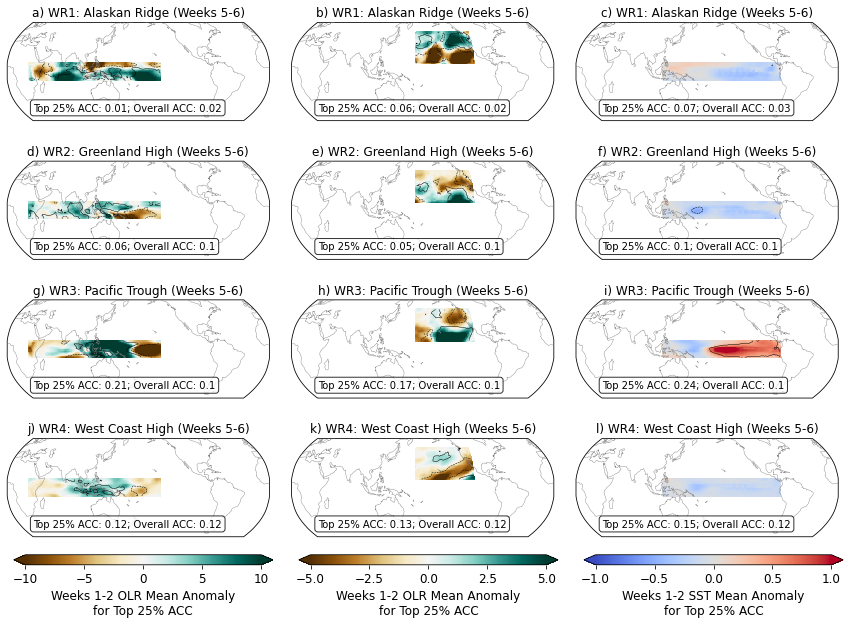

In [63]:
# ---

proj = ccrs.Robinson(central_longitude=180)

fig, axs = plt.subplots(
    4, 3, subplot_kw=dict(projection=proj), figsize=(12, 8))

# ---

pm_tpac = axs[0][0].pcolormesh(
    lons_tpac, lats_tpac, cesm_c0_tpac_1256,
    transform=ccrs.PlateCarree(), vmin=-10, vmax=10, cmap='BrBG')

axs[0][0].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[0][0].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[0][0].contour(
    lons_tpac, lats_tpac, era5_c0_tpac_1256, levels=[-5, 5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[0][0].set_title('a) WR1: Alaskan Ridge (Weeks 5-6)', fontsize=12)
axs[0][0].margins(x=0, y=0)

axs[0][0].annotate(
    f'Top 25% ACC: {np.around(top0_tpac_1256, 2)}; Overall ACC: {np.around(all0_tpac_1256, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8),
    xycoords='axes fraction', zorder=100)


# ---

axs[1][0].pcolormesh(lons_tpac, lats_tpac, cesm_c1_tpac_1256,
                     transform=ccrs.PlateCarree(),
                     vmin=-10, vmax=10, cmap='BrBG')

axs[1][0].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[1][0].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[1][0].contour(
    lons_tpac, lats_tpac, era5_c1_tpac_1256, levels=[-5, 5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[1][0].set_title('d) WR2: Greenland High (Weeks 5-6)', fontsize=12)
axs[1][0].margins(x=0, y=0)

axs[1][0].annotate(
    f'Top 25% ACC: {np.around(top1_tpac_1256, 2)}; Overall ACC: {np.around(all1_tpac_1256, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[2][0].pcolormesh(lons_tpac, lats_tpac, cesm_c2_tpac_1256,
                     transform=ccrs.PlateCarree(),
                     vmin=-10, vmax=10, cmap='BrBG')

axs[2][0].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[2][0].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[2][0].contour(
    lons_tpac, lats_tpac, era5_c2_tpac_1256, levels=[-5, 5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[2][0].set_title('g) WR3: Pacific Trough (Weeks 5-6)', fontsize=12)
axs[2][0].margins(x=0, y=0)

axs[2][0].annotate(
    f'Top 25% ACC: {np.around(top2_tpac_1256, 2)}; Overall ACC: {np.around(all2_tpac_1256, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[3][0].pcolormesh(lons_tpac, lats_tpac, cesm_c3_tpac_1256,
                     transform=ccrs.PlateCarree(),
                     vmin=-10, vmax=10, cmap='BrBG')

axs[3][0].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[3][0].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[3][0].contour(
    lons_tpac, lats_tpac, era5_c3_tpac_1256, levels=[-5, 5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[3][0].set_title('j) WR4: West Coast High (Weeks 5-6)', fontsize=12)
axs[3][0].margins(x=0, y=0)

axs[3][0].annotate(
    f'Top 25% ACC: {np.around(top3_tpac_1256, 2)}; Overall ACC: {np.around(all3_tpac_1256, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

pm_npac = axs[0][1].pcolormesh(
    lons_npac, lats_npac, cesm_c0_npac_1256,
    transform=ccrs.PlateCarree(),
    vmin=-5, vmax=5, cmap='BrBG')

axs[0][1].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[0][1].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[0][1].contour(
    lons_npac, lats_npac, era5_c0_npac_1256, levels=[-2.5, 2.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[0][1].set_title('b) WR1: Alaskan Ridge (Weeks 5-6)', fontsize=12)
axs[0][1].margins(x=0, y=0)

axs[0][1].annotate(
    f'Top 25% ACC: {np.around(top0_npac_1256, 2)}; Overall ACC: {np.around(all0_npac_1256, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[1][1].pcolormesh(lons_npac, lats_npac, cesm_c1_npac_1256,
                     transform=ccrs.PlateCarree(),
                     vmin=-5, vmax=5, cmap='BrBG')

axs[1][1].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[1][1].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[1][1].contour(
    lons_npac, lats_npac, era5_c1_npac_1256, levels=[-2.5, 2.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[1][1].set_title('e) WR2: Greenland High (Weeks 5-6)', fontsize=12)
axs[1][1].margins(x=0, y=0)

axs[1][1].annotate(
    f'Top 25% ACC: {np.around(top1_npac_1256, 2)}; Overall ACC: {np.around(all1_npac_1256, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[2][1].pcolormesh(lons_npac, lats_npac, cesm_c2_npac_1256,
                     transform=ccrs.PlateCarree(),
                     vmin=-5, vmax=5, cmap='BrBG')

axs[2][1].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[2][1].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[2][1].contour(
    lons_npac, lats_npac, era5_c2_npac_1256, levels=[-2.5, 2.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[2][1].set_title('h) WR3: Pacific Trough (Weeks 5-6)', fontsize=12)
axs[2][1].margins(x=0, y=0)

axs[2][1].annotate(
    f'Top 25% ACC: {np.around(top2_npac_1256, 2)}; Overall ACC: {np.around(all2_npac_1256, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[3][1].pcolormesh(lons_npac, lats_npac, cesm_c3_npac_1256,
                     transform=ccrs.PlateCarree(),
                     vmin=-5, vmax=5, cmap='BrBG')

axs[3][1].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[3][1].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[3][1].contour(
    lons_npac, lats_npac, era5_c3_npac_1256, levels=[-2.5, 2.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[3][1].set_title('k) WR4: West Coast High (Weeks 5-6)', fontsize=12)
axs[3][1].margins(x=0, y=0)

axs[3][1].annotate(
    f'Top 25% ACC: {np.around(top3_npac_1256, 2)}; Overall ACC: {np.around(all3_npac_1256, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

pm_sstk = axs[0][2].pcolormesh(
    lons_sstk, lats_sstk, cesm_c0_sstk_1256,
    transform=ccrs.PlateCarree(),
    vmin=-1, vmax=1, cmap='coolwarm')

axs[0][2].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[0][2].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[0][2].contour(
    lons_sstk, lats_sstk, era5_c0_sstk_1256, levels=[-0.5, 0.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[0][2].set_title('c) WR1: Alaskan Ridge (Weeks 5-6)', fontsize=12)
axs[0][2].margins(x=0, y=0)

axs[0][2].annotate(
    f'Top 25% ACC: {np.around(top0_sstk_1256, 2)}; Overall ACC: {np.around(all0_sstk_1256, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[1][2].pcolormesh(lons_sstk, lats_sstk, cesm_c1_sstk_1256,
                     transform=ccrs.PlateCarree(),
                     vmin=-1, vmax=1, cmap='coolwarm')

axs[1][2].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[1][2].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[1][2].contour(
    lons_sstk, lats_sstk, era5_c1_sstk_1256, levels=[-0.5, 0.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[1][2].set_title('f) WR2: Greenland High (Weeks 5-6)', fontsize=12)
axs[1][2].margins(x=0, y=0)

axs[1][2].annotate(
    f'Top 25% ACC: {np.around(top1_sstk_1256, 2)}; Overall ACC: {np.around(all1_sstk_1256, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[2][2].pcolormesh(lons_sstk, lats_sstk, cesm_c2_sstk_1256,
                     transform=ccrs.PlateCarree(),
                     vmin=-1, vmax=1, cmap='coolwarm')

axs[2][2].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[2][2].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[2][2].contour(
    lons_sstk, lats_sstk, era5_c2_sstk_1256, levels=[-0.5, 0.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[2][2].set_title('i) WR3: Pacific Trough (Weeks 5-6)', fontsize=12)
axs[2][2].margins(x=0, y=0)

axs[2][2].annotate(
    f'Top 25% ACC: {np.around(top2_sstk_1256, 2)}; Overall ACC: {np.around(all2_sstk_1256, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

axs[3][2].pcolormesh(lons_sstk, lats_sstk, cesm_c3_sstk_1256,
                     transform=ccrs.PlateCarree(),
                     vmin=-1, vmax=1, cmap='coolwarm')

axs[3][2].coastlines(
    resolution='110m', facecolor='none', color='grey', linewidth=0.4, zorder=10)

axs[3][2].set_extent([0, 359, -60, 60], crs=ccrs.PlateCarree())

cntr = axs[3][2].contour(
    lons_sstk, lats_sstk, era5_c3_sstk_1256, levels=[-0.5, 0.5],
    linewidths=0.5, transform=ccrs.PlateCarree(), colors='k', zorder=100)

cntr.monochrome = True
for col, ls in zip(cntr.collections, cntr._process_linestyles()):
    col.set_linestyle(ls)

axs[3][2].set_title('l) WR4: West Coast High (Weeks 5-6)', fontsize=12)
axs[3][2].margins(x=0, y=0)

axs[3][2].annotate(
    f'Top 25% ACC: {np.around(top3_sstk_1256, 2)}; Overall ACC: {np.around(all3_sstk_1256, 2)}',
    [0.1, 0.1], fontsize=10, bbox=dict(boxstyle="round", fc="w", alpha=0.8), 
    xycoords='axes fraction', zorder=100)

# ---

cbar_ax = fig.add_axes([0.02, 0.0, 0.3, 0.0175])
cbar = fig.colorbar(pm_tpac, cax=cbar_ax, ticks=[-10, -5, 0, 5, 10],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Weeks 1-2 OLR Mean Anomaly\nfor Top 25% ACC', fontsize=12)

cbar_ax = fig.add_axes([0.35, 0.0, 0.3, 0.0175])
cbar = fig.colorbar(pm_npac, cax=cbar_ax, ticks=[-5, -2.5, 0, 2.5, 5],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Weeks 1-2 OLR Mean Anomaly\nfor Top 25% ACC', fontsize=12)

cbar_ax = fig.add_axes([0.68, 0.0, 0.3, 0.0175])
cbar = fig.colorbar(pm_sstk, cax=cbar_ax, ticks=[-1, -0.5, 0, 0.5, 1],
                    orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Weeks 1-2 SST Mean Anomaly\nfor Top 25% ACC', fontsize=12)

# ---

plt.tight_layout()
plt.savefig("fig_week1256.pdf", bbox_inches='tight')
plt.show()

# ---